# 0. Import libs

In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import random
from collections import Counter
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 30})
import pandas as pd
import numpy as np
import scipy.interpolate
from scipy.interpolate import interp1d
from src.utils.Notebook_imports import *
from src.data.Preprocess import clip_quantile
from src.data.Dataset import load_phase_reg_exp

from ipywidgets import interact
import ipywidgets as widgets
from IPython.core.display import display, HTML
%matplotlib inline
%reload_ext autoreload
%autoreload 2

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


## 0.1 Link to medical definition of the cardiac function

[source](https://next.amboss.com/de/article/xL0E-g)

Systole
1.) Anspannungsphase

    Hauptfunktion: Ventrikel kontrahieren sich
    Ablauf
        Alle Klappen sind geschlossen und die Ventrikel sind mit Blut gefüllt
        Isovolumetrische Kontraktion des Arbeitsmyokards 

    Druckanstieg in den Ventrikeln, bis der Druck in der Aorta bzw. dem Truncus pulmonalis überschritten ist
    Passive Öffnung der Taschenklappen (Pulmonal- und Aortenklappe) → Beginn der Austreibungsphase

Status des linken Ventrikels

    Druck: Anstieg von ca. 8 mmHg auf ca. 80 mmHg 

Volumen: Gleichbleibend ca. 150 mL (isovolumetrische Anspannung)
2.) Austreibungsphase

    Hauptfunktion: Blut wird aus Ventrikeln in Kreislauf und Lunge gepumpt
    Ablauf
        Blut strömt aus den Ventrikeln in den Truncus pulmonalis bzw. die Aorta (Großteil bereits zu Beginn der Austreibungsphase)
        Weitere Kontraktion des Myokards (beginnend am distalen Septum und der Herzspitze)
        Wanddicke der Ventrikel ↑ und Innendurchmesser der Ventrikel ↓
        Druck in den Ventrikeln ↑ (Laplace-Gesetz) → Blutvolumen ↓ im Ventrikel
        Druck ↓ langsam im Ventrikel (bis unter den Druck der Aorta bzw. Truncus pulmonalis)
        Schluss der Taschenklappen → Beginn der Entspannungsphase
    Status des linken Ventrikels
        Druck: Anstieg von ca. 80 mmHg auf ca. 120 mmHg, danach Absinken 

Volumen: Austreibung von ca. 90 mL Schlagvolumen (150 mL → 60 mL)
Diastole
3.) Entspannungsphase

    Hauptfunktion: Ventrikel entspannen sich
    Ablauf
        Alle Herzklappen sind geschlossen (Volumen bleibt konstant)
        Weitere Entspannung des Myokards (Druck ↓ in den Ventrikeln)
        Isovolumetrische Entspannung
        Ventrikeldruck fällt unter den Druck in den Vorhöfen
        Segelklappen öffnen sich → Beginn der Füllungsphase
    Status des linken Ventrikels
        Druck: Absinken auf ca. 10 mmHg 

Volumen: Gleichbleibend ca. 60 mL (isovolumetrische Entspannung)
4.) Füllungsphase

    Hauptfunktion: Ventrikel füllen sich erneut mit Blut
    Ablauf
        Die Ventilebene hebt sich und "stülpt" sich über die Blutsäule in den Vorhöfen (Ventilebenenmechanismus)
        Am Ende der Diastole kontrahieren die Vorhöfe kurz
        Druck im Ventrikel übersteigt den Druck der Vorhöfe
        Schluss Segelklappen → Beginn der Anspannungsphase
    Status des linken Ventrikels
        Druck: ca. 8 mmHg 

Volumen: Füllung mit ca. 90 mL (60 mL → 150 mL)

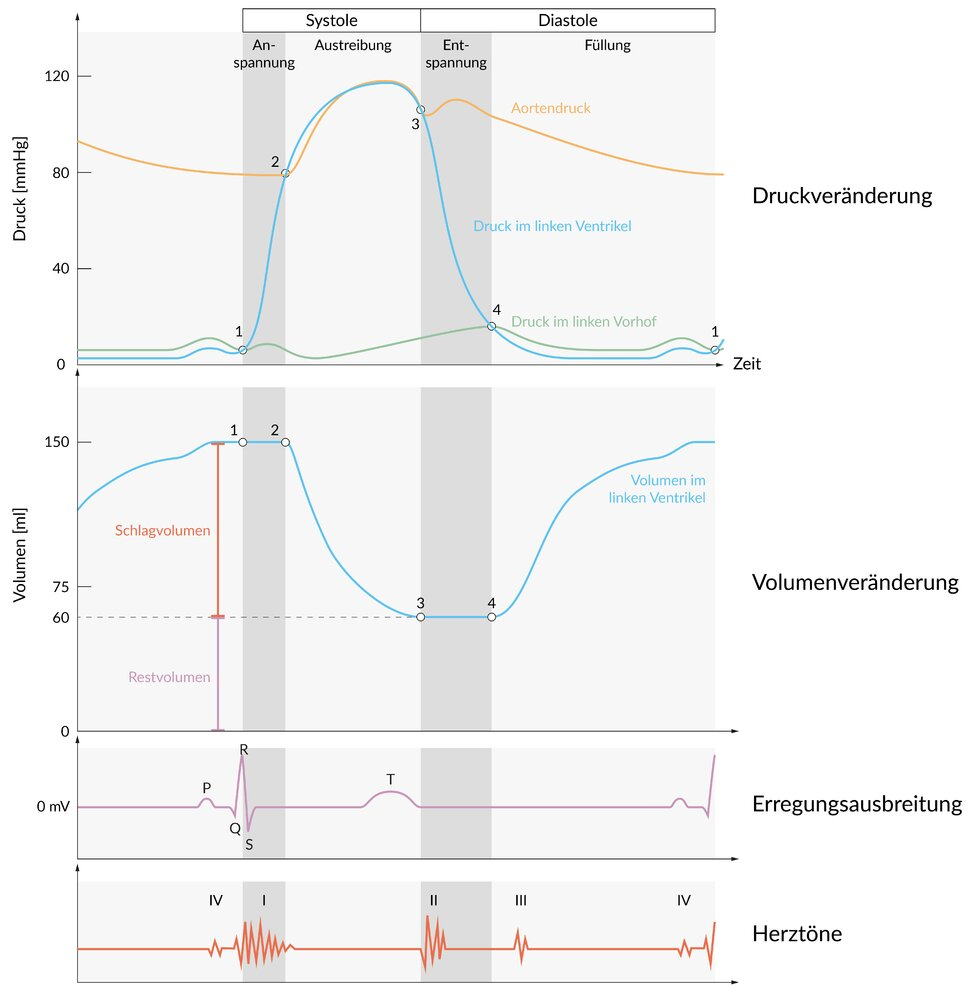

In [2]:
from IPython import display as disp
disp.Image("https://media-de.amboss.com/media/thumbs/big_5f22e89d3edf1.jpg")

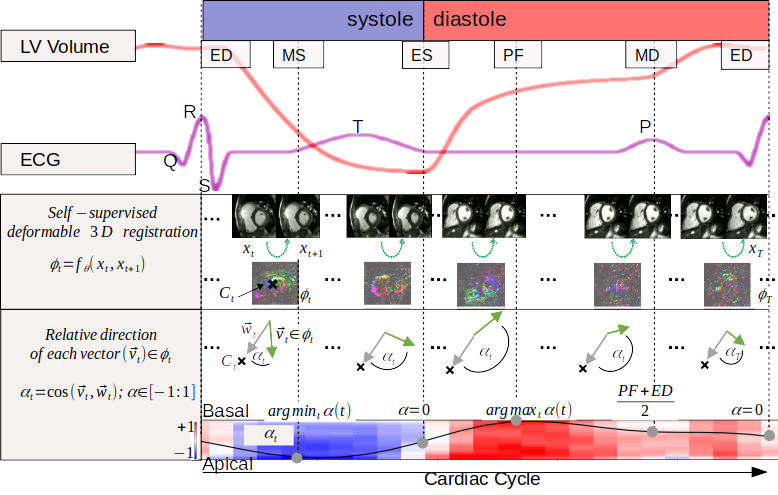

In [3]:
# mapping between the 5 defined cardiac phases and the lv volume curve
disp.Image("notebooks/Dataset/overview.png")

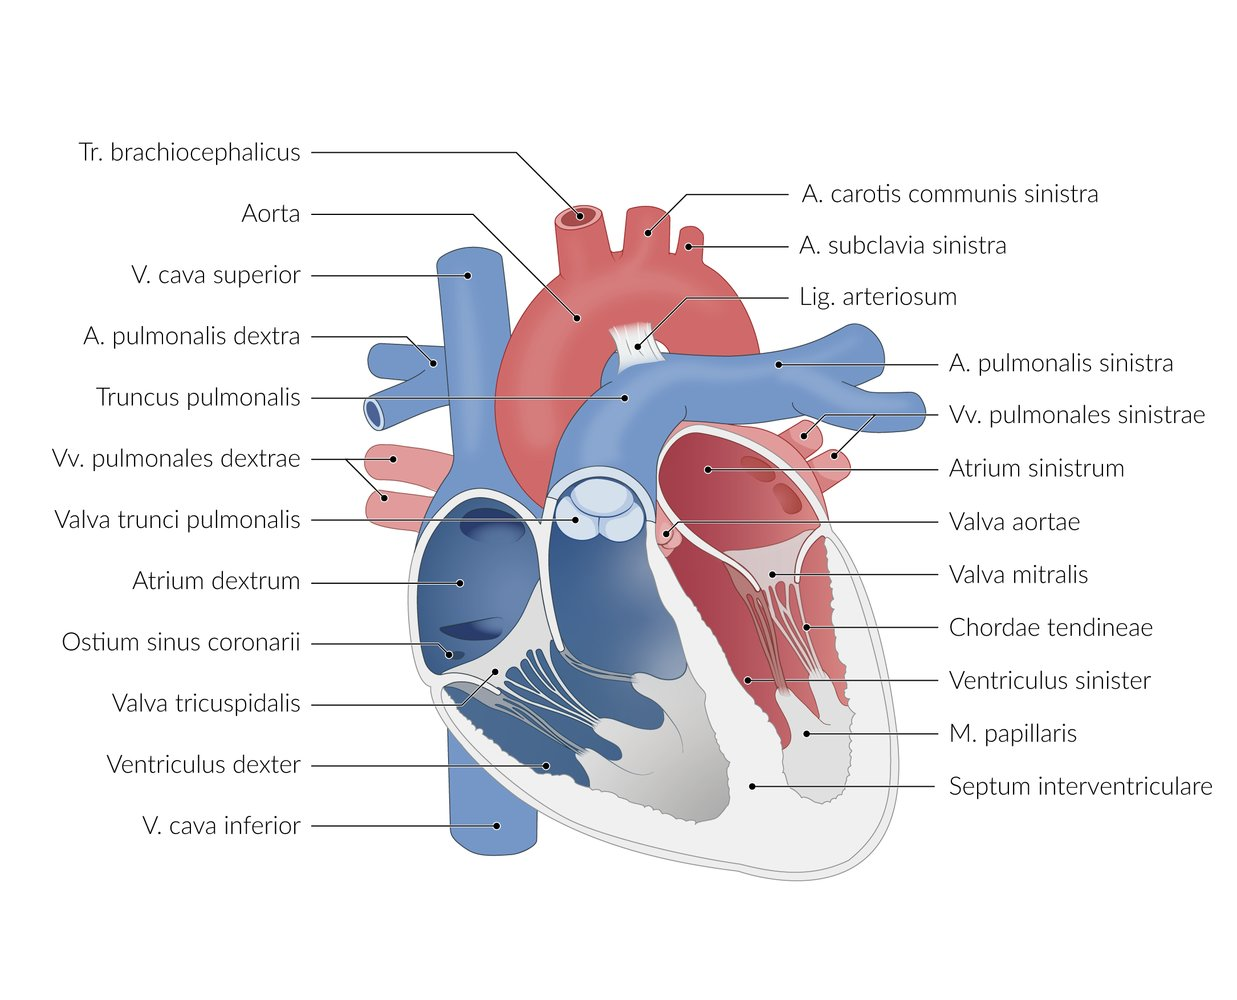

In [4]:
disp.Image("https://media-de.amboss.com/media/thumbs/big_5e147f74d36fe.jpg")

# 1. Load phase-vector and gt/pred from a project

In [5]:
from ipyfilechooser import FileChooser
vects_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/roll2/'), '')
display(vects_chooser)

FileChooser(path='/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/roll2', filename='', title='HTML(value='', l…

In [53]:
# load all files of this experiment
nda_vects, gt, pred, gt_len, mov, patients = load_phase_reg_exp(vects_chooser.selected)

['/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/roll2/mse/phaseloss0_2lstm32_acdc/2022-03-27_09_29/moved/vects_f0.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/roll2/mse/phaseloss0_2lstm32_acdc/2022-03-27_09_29/moved/vects_f1.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/roll2/mse/phaseloss0_2lstm32_acdc/2022-03-27_09_29/moved/vects_f2.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/roll2/mse/phaseloss0_2lstm32_acdc/2022-03-27_09_29/moved/vects_f3.npy']
(99, 40, 16, 64, 64, 3)
['/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/roll2/mse/phaseloss0_2lstm32_acdc/2022-03-27_09_29/pred/gtpred_fold0.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/roll2/mse/phaseloss0_2lstm32_acdc/2022-03-27_09_29/pred/gtpred_fold1.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/roll2/mse/phaseloss0_2lstm32_acdc/2022-03-27_09_29/pred/gtpred_fold2.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/roll2/mse/phaseloss0_2lstm32_acdc/2022-03-27_09_29/pred/gtpred_fold3.

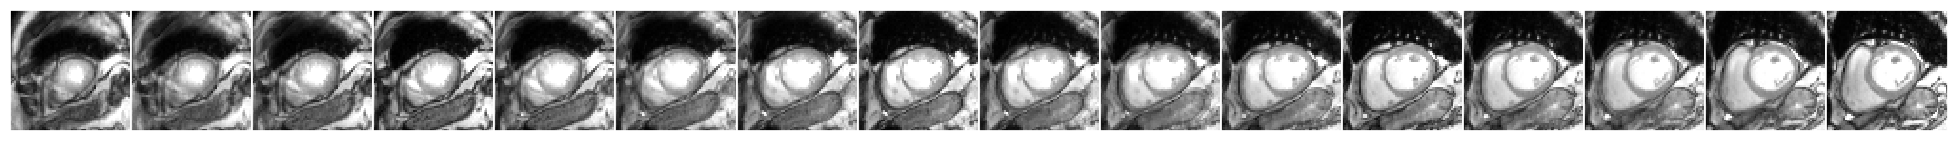

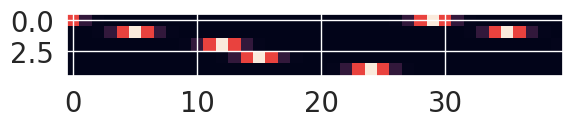

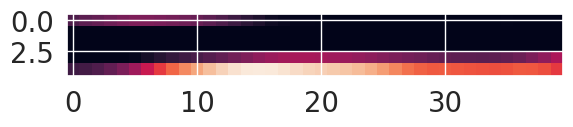

In [48]:
# plot one example moved timestep of one patient = one 3D volume
# make sure that it looks valid and
# goes from apex to base
from src.visualization.Visualize import show_2D_or_3D
temp = mov[10,0,...,0]
_ = show_2D_or_3D(temp, cmap='gray', interpolation='none');plt.show()
plt.imshow(gt[0].T);plt.show()
plt.imshow(pred[0].T)

# 2. Import / define some helper functions

In [49]:
import tensorflow as tf
from src.models.KerasLayers import get_angle_tf,get_centers_tf,get_idxs_tf
# define two lambdas as wrapper for the angle and min/max normalisation within variable ranges
flow2direction_lambda_old = tf.keras.layers.Lambda(
            lambda x: get_angle_tf(x, centers_tensor), name='flow2direction')
flow2direction_lambda = tf.keras.layers.Lambda(
            lambda x: get_angle_tf(x[0], x[1]), name='flow2direction')
minmax_lambda = lambda x : x[1] + (((x[0] - np.min(x[0])) * (x[2]-x[1]))/(np.max(x[0]) - np.min(x[0]) + sys.float_info.epsilon))
def get_focus_tf(p,dim=[12,12,12]):
    return tf.cast(
        tf.tile(tf.convert_to_tensor([*p])[tf.newaxis, tf.newaxis, tf.newaxis, ...],
                (*dim, 1)), tf.float32)
# define some central params
lower, mid, upper = -1,0, 1

# 3. Align the direction and magnitude by ED Phase and resample to a fix length

In [9]:
# align norm and direction by the cardiac phase ED
# resample all 1D feature vectors to the same length and min/max normalise into [0,1] and [-1,1]
# this should help to validate the pre-defined rules, detect outliers, and if both together explains the cardiac phases
target_t = 30
norms = []
dirs= []
cycle_len=[]
gt_ind = []
gt_ind_rolled = []
xval = np.linspace(0,1,target_t)
centers_tensor = None

    
def align_and_resample(i):
    if i%20==0:print('processing patient : {}'.format(i))
    global target_t, norms, dirs, cycle_len, gt_ind, gt_ind_rolled, xval, centers_tensor
    cardiac_cycle_length = int(gt_len[i,:,0].sum())
    cycle_len.append(cardiac_cycle_length)
    ind = np.argmax(gt[i][:cardiac_cycle_length],axis=0)
    gt_onehot = gt[i][:cardiac_cycle_length]
    gt_ind.append(ind)
    nda = nda_vects[i]
    
    dir_axis=0
    gt_ed = ind[0]
    temp = nda[:cardiac_cycle_length]
    
    if centers_tensor is None:
        print('init center')
        dim = temp.shape[1:-1]
        idx = get_idxs_tf(dim)
        c = get_centers_tf(dim)
        centers = c - idx
        centers_tensor = centers[tf.newaxis, ...]
    
    # direction
    directions = flow2direction_lambda([temp,centers_tensor])[...,0]
    # direction mean
    directions = np.mean(directions,axis=(1,2,3))
    # direction ed aligned
    directions = np.roll(directions, -1*gt_ed)
    # direction interpolate to unique length
    f = interp1d(np.linspace(0,1,directions.shape[0]), directions, kind='linear')
    directions = f(xval)
    # direction min/max normalised between -1,1
    directions = minmax_lambda([directions,lower,upper])
    
    # magnitude/norm as mean
    norm_full = np.linalg.norm(temp, axis=-1)
    norm_nda = norm_full.mean(axis=(1,2,3))
    # norm ed aligned
    norm_nda = np.roll(norm_nda, -1*gt_ed)
    # interpolate to unique length
    norm_nda = np.interp(xval, np.linspace(0,1,norm_nda.shape[0]), norm_nda)
    # norm min/max aligned to 0,1
    norm_nda = minmax_lambda([norm_nda,mid,upper])
    
    # roll, scale, round and clip the gt indicies, to get an aligned distribution of the labels
    gt_onehot_rolled = np.roll(gt_onehot, -1*gt_ed, axis=0)
    resize_factor = target_t/cardiac_cycle_length
    gt_onehot_rolled = np.argmax(gt_onehot_rolled,axis=0)
    gt_onehot_rolled = np.clip(np.rint(gt_onehot_rolled * resize_factor),a_min=0,a_max=target_t-1)
    gt_ind_rolled.append(gt_onehot_rolled)
    
    norms.append(norm_nda)
    dirs.append(directions)

#######################################################################
_ = list(map(align_and_resample,list(range(nda_vects.shape[0]))))
########################################################################
# get the mean values
gt_ind_scaled = np.stack(gt_ind_rolled, axis=0)
gt_ind = np.stack(gt_ind,axis=0)
cycle_len = np.stack(cycle_len, axis=0)
norms = np.stack(norms, axis=0)
dirs = np.stack(dirs, axis=0)
norms_m = [norms.mean(axis=0)]
dirs_m=[dirs.mean(axis=0)]

processing patient : 0
init center
processing patient : 20
processing patient : 40
processing patient : 60
processing patient : 80


mean: 
 ED     0.000000
MS     5.858586
ES    12.272727
PF    18.121212
MD    26.464646
dtype: float64 
std: 
 ED    0.000000
MS    1.399782
ES    2.393947
PF    3.034740
MD    1.618220
dtype: float64


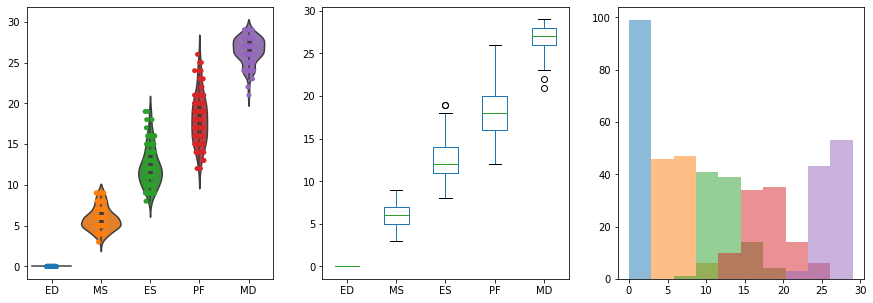

In [10]:
# plot the distribution of the aligned and scaled gt indicies
# just from the sequence order:
# patient 5cxhn75u_2006-08-02 is wrong labelled, MD after ED
# from the csv: 
#ED#MS#ES#PF#MD#
#17, 3, 8, 10, 18
# need to clear
# patients[temp[temp['MD']<10].index[0]]
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
temp = pd.DataFrame(gt_ind_scaled, columns=phases)
print('mean: \n',temp.mean(),'\nstd: \n' ,temp.std())
ax1 = sb.violinplot(data=temp, ax=ax1)
ax1 = sb.stripplot(data=temp, ax=ax1)
_ = temp.plot(kind='box', ax=ax2)
_ = temp.plot(kind='hist', ax=ax3, legend=None, alpha=0.5)
_ = ax3.set_ylabel('')

## 3.1 Plot the mean +/- SD direction & magnitude of all patients over time

Each patient-specific frame2frame deformation is:
- Croped by cardiac cycle length
- Starts at GT ED phase (np.roll)
- Linearly interpolated to an unique length of 40 frames

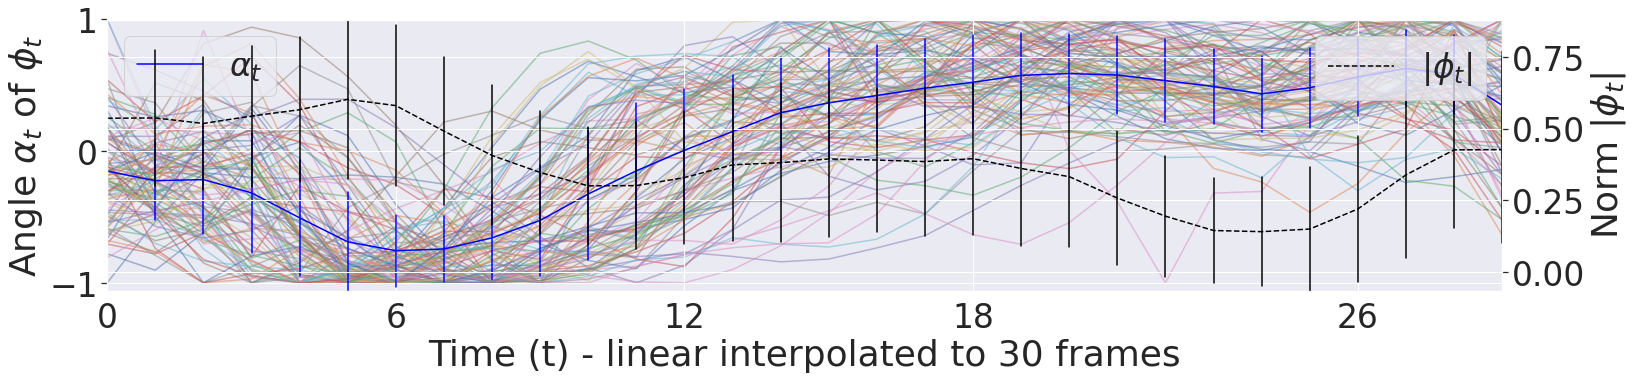

In [11]:
import seaborn as sb
sb.set_context('paper')
sb.set(font_scale = 3)
fig, ax = plt.subplots(figsize=(25,5))
ax.margins(0,0)
ax2 = ax.twinx()
ax2.margins(0,0)
for n in dirs:
    _ = ax.plot(n, alpha=0.5, zorder=0)

df = pd.DataFrame(dirs).melt()
_ = sb.lineplot(x='variable', y='value',data=df, color='blue', label=r'$\alpha_t$',ci='sd',err_style='bars',zorder=2,legend=False,ax=ax)
#_ = ax.set_title('Mean direction +/- SD - aligned at ED')
_ = ax.set_xticks(np.rint(gt_ind_scaled.mean(axis=0)), minor=False)
_ = ax.set_xlabel('Time (t) - linear interpolated to 30 frames')
_ = ax.set_ylabel(r'Angle $\alpha_t$ of $\phi_t$')
_ = ax.legend(loc='upper left')

df = pd.DataFrame(norms).melt()
_ = sb.lineplot(x='variable', y='value',data=df, color='black', label=r'|$\phi_t$|',ci='sd', linestyle='dashed',err_style='bars',zorder=2,legend=False,ax=ax2)
_ = ax2.set_ylabel(r'Norm |$\phi_t$|')
_ = ax2.legend(loc='upper right')

### 3.1.1 map inference data with metadata

Load metadata such as the pathology, 

- currently only possible for ACDC, 
- later we can use the TOF binary classes

In [174]:
folds_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/'), '')
display(folds_chooser)

FileChooser(path='/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc', filename='', title='HTML(value='', la…

In [175]:
# define df and helper for pathology extractio
# this should have the same order as our inference data
#df_meta = pd.read_csv(folds_chooser.selected)
df_meta = pd.read_csv('/mnt/sds/sd20i001/sven/data/acdc/02_imported_4D_unfiltered/df_kfold.csv')
df_meta = df_meta.loc[:, ~df_meta.columns.str.contains('^Unnamed')]
df_meta = df_meta[df_meta.patient != 'patient090']  #we excluded this patient
df_meta

fold modality pathology     patient phase  \
0        3    train      MINF  patient050    ED   
1        3    train      MINF  patient050    ES   
2        3    train       NOR  patient070    ED   
3        3    train       NOR  patient070    ES   
4        3    train        RV  patient100    ES   
...    ...      ...       ...         ...   ...   
1595     0    train       NOR  patient072    ED   
1596     0    train      MINF  patient045    ES   
1597     0    train      MINF  patient045    ED   
1598     0    train       HCM  patient032    ES   
1599     0    train       HCM  patient032    ED   

                                                 x_path  \
0     data/raw/ACDC/3D/all/patient050/patient050_fra...   
1     data/raw/ACDC/3D/all/patient050/patient050_fra...   
2     data/raw/ACDC/3D/all/patient070/patient070_fra...   
3     data/raw/ACDC/3D/all/patient070/patient070_fra...   
4     data/raw/ACDC/3D/all/patient100/patient100_fra...   
...                                                 ...   
1595  data/raw/ACDC/3D/train/patient072/patient072_f...   
1596  data/raw/ACDC/3D/train/patient045/patient045_f...   
1597  data/raw/ACDC/3D/train/patient045/patient045_f...   
1598  data/raw/ACDC/3D/train/patient032/patient032_f...   
1599  data/raw/ACDC/3D/train/patient032/patient032_f...   

                                                 y_path  
0     data/raw/ACDC/3D/all/patient050/patient050_fra...  
1     data/raw/ACDC/3D/all/patient050/patient050_fra...  
2     data/raw/ACDC/3D/all/patient070/patient070_fra...  
3     data/raw/ACDC/3D/all/patient070/patient070_fra...  
4     data/raw/ACDC/3D/all/patient100/patient100_fra...  
...                                                 ...  
1595  data/raw/ACDC/3D/train/patient072/patient072_f...  
1596  data/raw/ACDC/3D/train/patient045/patient045_f...  
1597  data/raw/ACDC/3D/train/patient045/patient045_f...  
1598  data/raw/ACDC/3D/train/patient032/patient032_f...  
1599  data/raw/ACDC/3D/train/patient032/patient032_f...  

[1584 rows x 7 columns]

In [176]:
patients_df = pd.DataFrame(patients, columns=['pat'])
patients_df['patient'] = patients_df['pat'].map(lambda x : x.split('_')[1])
patients_df['fold'] = patients_df['pat'].map(lambda x : x.split('_')[0])
patients_df

pat     patient fold
0   0_patient001_4d.nii.gz\n  patient001    0
1   0_patient002_4d.nii.gz\n  patient002    0
2   0_patient009_4d.nii.gz\n  patient009    0
3   0_patient016_4d.nii.gz\n  patient016    0
4   0_patient018_4d.nii.gz\n  patient018    0
..                       ...         ...  ...
94  3_patient087_4d.nii.gz\n  patient087    3
95  3_patient088_4d.nii.gz\n  patient088    3
96  3_patient091_4d.nii.gz\n  patient091    3
97  3_patient093_4d.nii.gz\n  patient093    3
98  3_patient095_4d.nii.gz\n  patient095    3

[99 rows x 3 columns]

In [177]:
temp = df_meta[df_meta['modality'] == 'test']
temp = temp[temp['phase']=='ED'].drop_duplicates(ignore_index=True, subset='patient')
merged_temp = pd.merge(left=patients_df, right=temp, how='inner', left_on='patient', right_on='patient')
merged_temp

pat     patient fold_x  fold_y modality pathology  \
0   0_patient001_4d.nii.gz\n  patient001      0       0     test       DCM   
1   0_patient002_4d.nii.gz\n  patient002      0       0     test       DCM   
2   0_patient009_4d.nii.gz\n  patient009      0       0     test       DCM   
3   0_patient016_4d.nii.gz\n  patient016      0       0     test       DCM   
4   0_patient018_4d.nii.gz\n  patient018      0       0     test       DCM   
..                       ...         ...    ...     ...      ...       ...   
94  3_patient087_4d.nii.gz\n  patient087      3       3     test        RV   
95  3_patient088_4d.nii.gz\n  patient088      3       3     test        RV   
96  3_patient091_4d.nii.gz\n  patient091      3       3     test        RV   
97  3_patient093_4d.nii.gz\n  patient093      3       3     test        RV   
98  3_patient095_4d.nii.gz\n  patient095      3       3     test        RV   

   phase                                             x_path  \
0     ED  data/raw/ACDC/3D/all/patient001/patient001_fra...   
1     ED  data/raw/ACDC/3D/all/patient002/patient002_fra...   
2     ED  data/raw/ACDC/3D/all/patient009/patient009_fra...   
3     ED  data/raw/ACDC/3D/all/patient016/patient016_fra...   
4     ED  data/raw/ACDC/3D/all/patient018/patient018_fra...   
..   ...                                                ...   
94    ED  data/raw/ACDC/3D/all/patient087/patient087_fra...   
95    ED  data/raw/ACDC/3D/all/patient088/patient088_fra...   
96    ED  data/raw/ACDC/3D/all/patient091/patient091_fra...   
97    ED  data/raw/ACDC/3D/all/patient093/patient093_fra...   
98    ED  data/raw/ACDC/3D/all/patient095/patient095_fra...   

                                               y_path  
0   data/raw/ACDC/3D/all/patient001/patient001_fra...  
1   data/raw/ACDC/3D/all/patient002/patient002_fra...  
2   data/raw/ACDC/3D/all/patient009/patient009_fra...  
3   data/raw/ACDC/3D/all/patient016/patient016_fra...  
4   data/raw/ACDC/3D/all/patient018/patient018_fra...  
..                                                ...  
94  data/raw/ACDC/3D/all/patient087/patient087_fra...  
95  data/raw/ACDC/3D/all/patient088/patient088_fra...  
96  data/raw/ACDC/3D/all/patient091/patient091_fra...  
97  data/raw/ACDC/3D/all/patient093/patient093_fra...  
98  data/raw/ACDC/3D/all/patient095/patient095_fra...  

[99 rows x 9 columns]

### 3.1.2 Interactive plot per pathology

In [178]:
# interactive plot per pathology
@interact
def plot_per_pathology(p=merged_temp.pathology.unique()):
    print(p)
    msk = merged_temp.pathology == p

    import seaborn as sb
    sb.set_context('paper')
    sb.set(font_scale = 2)
    fig, ax = plt.subplots(figsize=(25,5))
    ax.margins(0,0)
    dirs_minf = dirs[msk]
    norms_minf = norms[msk]
    for n in dirs_minf:
        _ = ax.plot(n, alpha=0.5, zorder=0)

    df = pd.DataFrame(dirs).melt()
    _ = sb.lineplot(x='variable', y='value',data=df, color='blue', label=r'$\alpha_t$',ci='sd',err_style='bars',zorder=2,legend=False,ax=ax)
    #_ = ax.set_title('Mean direction +/- SD - aligned at ED')
    _ = ax.set_xlabel('Time (t) - linear interpolated to 40 frames')
    _ = ax.set_ylabel(r'Angle $\alpha_t$ of $\phi_t$')
    _ = ax.legend(loc='upper left')
    ax2 = ax.twinx()
    ax2.margins(0,0)
    df = pd.DataFrame(norms).melt()
    _ = sb.lineplot(x='variable', y='value',data=df, color='black', label=r'|$\phi_t$|',ci='sd', linestyle='dashed',err_style='bars',zorder=2,legend=False,ax=ax2)
    _ = ax2.set_ylabel(r'Norm |$\phi_t$|')

    _ = ax2.legend(loc='upper right')
    plt.show()

interactive(children=(Dropdown(description='p', options=('DCM', 'HCM', 'MINF', 'NOR', 'RV'), value='DCM'), Out…

### 3.1.3 Create one figure, with one curve per pathology

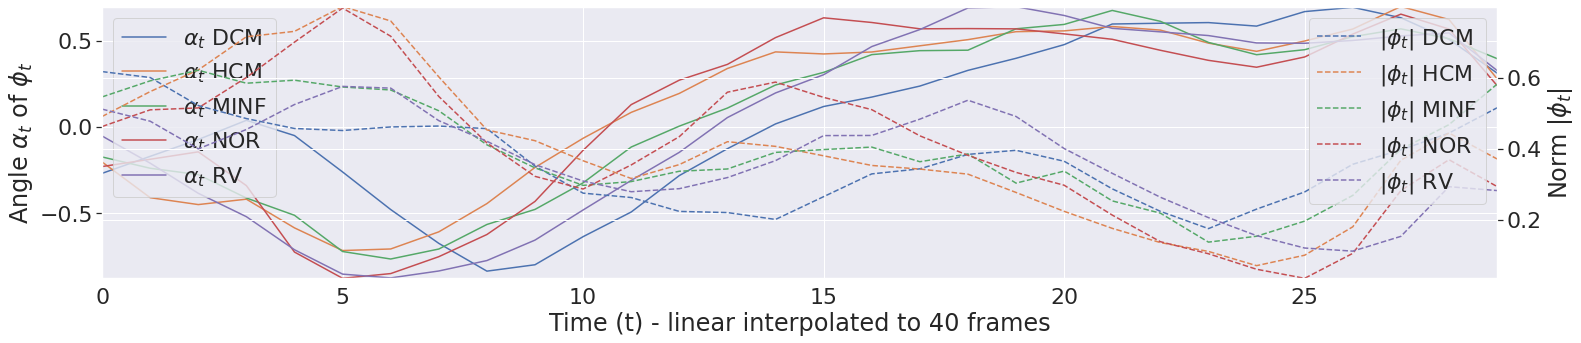

In [179]:
import seaborn as sb
sb.set_context('paper')
sb.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(25,5))
ax2 = ax.twinx()
ax2.margins(0,0)
ax.margins(0,0)
for p in merged_temp.pathology.unique():
    msk = merged_temp.pathology == p
    dirs_p = dirs[msk]
    norms_p = norms[msk]    
    df = pd.DataFrame(dirs_p).melt()
    _ = sb.lineplot(x='variable', y='value',data=df, label=r'$\alpha_t$ {}'.format(p),ci='sd',err_style=None,zorder=2,legend=False,ax=ax)
    _ = ax.set_xlabel('Time (t) - linear interpolated to 40 frames')
    _ = ax.set_ylabel(r'Angle $\alpha_t$ of $\phi_t$')
    _ = ax.legend(loc='upper left')
    df = pd.DataFrame(norms_p).melt()
    _ = sb.lineplot(x='variable', y='value',data=df, label=r'|$\phi_t$| {}'.format(p),ci='sd', linestyle='dashed',err_style=None,zorder=2,legend=False,ax=ax2)
    _ = ax2.set_ylabel(r'Norm |$\phi_t$|')
    _ = ax2.legend(loc='upper right')
    
plt.show()

ED: no transition found between 11-0 , closest id to 0: 2, ed = 13
ED: no transition found between 12-5 , closest id to 0: 4, ed = 16
ED: no transition found between 25-2 , closest id to 0: 6, ed = 31
ED: no transition found between 11-4 , closest id to 0: 19, ed = 30
pf not clear, set to ES 20 + 1
ED: no transition found between 9-0 , closest id to 0: 2, ed = 11
ED: no transition found between 9-4 , closest id to 0: 22, ed = 31
ED: no transition found between 14-1 , closest id to 0: 16, ed = 30
ED: no transition found between 13-1 , closest id to 0: 10, ed = 23


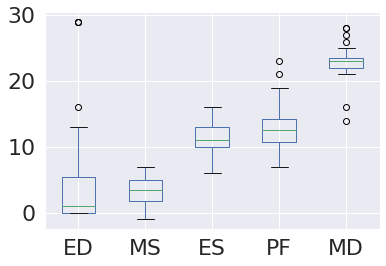

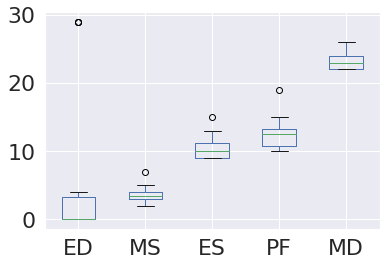

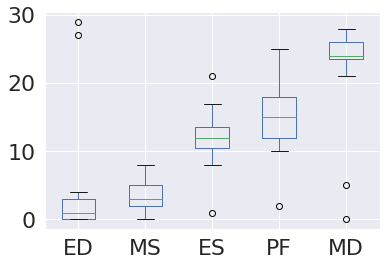

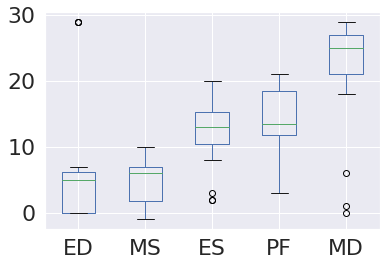

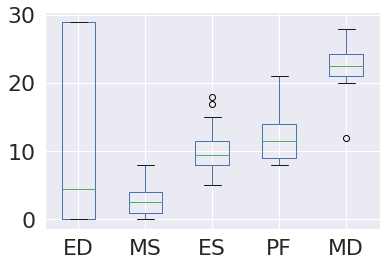

In [180]:
# predict per pathology, on aligned curves
import seaborn as sb
sb.set_context('paper')
sb.set(font_scale = 2)
ind_all = []

for p in df_meta.pathology.unique():
    msk = merged_temp.pathology == p
    dirs_p = dirs[msk]
    norms_p = norms[msk]
    ind_ = np.stack([detect_phases(elem, len(elem)) for elem in dirs_p], axis=0)
    _ = pd.DataFrame(ind_, columns=phases).plot(kind='box')
    ind_all.extend(ind_)

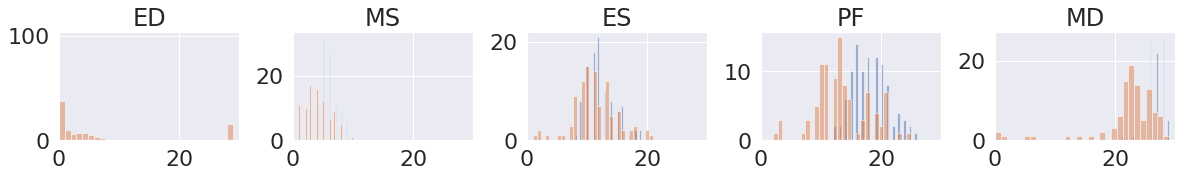

In [181]:
fig, ax = plt.subplots(1,5, figsize=(20,2))
_ = pd.DataFrame(gt_ind_scaled, columns=phases).hist(ax=ax,bins=30, alpha=0.5)
_ = pd.DataFrame(ind_all, columns=phases).hist(ax=ax,bins=30, alpha=0.5)
_ = [a.set_xlim(0,30) for a in ax.flatten()]

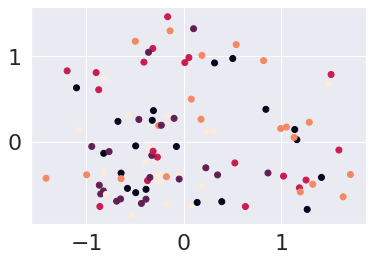

In [182]:
# scatterplot per pathology, t as dymension
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
y = np.zeros(99)
for i,p in enumerate(df_meta.pathology.unique()):
    msk = merged_temp.pathology == p
    y[msk] = i
#low_dim = TSNE(n_components=2).fit_transform(norms)
low_dim = PCA(n_components=2).fit_transform(norms)
_ =plt.scatter(low_dim[:,0],low_dim[:,1], c=y)

### 3.1.n Further tests for plotting

In [ ]:
# plot one line per patient - norm
fig, ax = plt.subplots(figsize=(25,5))
for n in norms:
    _ = plt.plot(n)
_ = ax.set_title('Magnitudes aligned at ED, resampling shape 40,')

In [ ]:
# plot one line per direction
fig, ax = plt.subplots(figsize=(25,5))
for n in dirs:
    _ = plt.plot(n)
_ = ax.set_title('Directions aligned at ED, resampling shape 40,')

In [ ]:
# plot one line per relative deformable axis (z,y,x deformation)
vects_1d = np.mean(nda_vects,axis=(2,3,4))
vects_1d_mean = np.mean(vects_1d, axis=0)
print(vects_1d.shape)                   

In [ ]:
# this should be very difficult to interpret, compared to the relative direction according to a focus point
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(25,15))
for n in vects_1d:
    _ = axes[0].plot(minmax_lambda([n[...,0],lower,upper]))
    _ = axes[1].plot(minmax_lambda([n[...,1],lower,upper]))
    _ = axes[2].plot(minmax_lambda([n[...,2],lower,upper]))
_ = axes[0].plot(minmax_lambda([vects_1d_mean[...,0],lower,upper]),linewidth=5)
_ = axes[1].plot(minmax_lambda([vects_1d_mean[...,1],lower,upper]),linewidth=5)
_ = axes[2].plot(minmax_lambda([vects_1d_mean[...,2],lower,upper]),linewidth=5)
#_ = ax.set_title('Directions aligned at ED, resampling shape 40,')

## 3.2 Extract the vectorfield of one example patient

- validation of inplane alignment and spatial order (detect apex and base orientation in vect)
- further static plotting tests
- validate corner specific slicing
- tests for norm based deformable masking

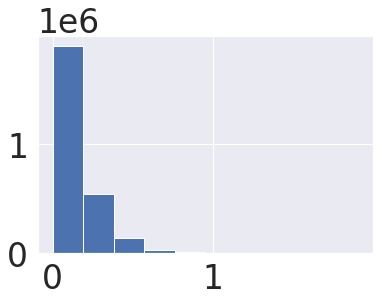

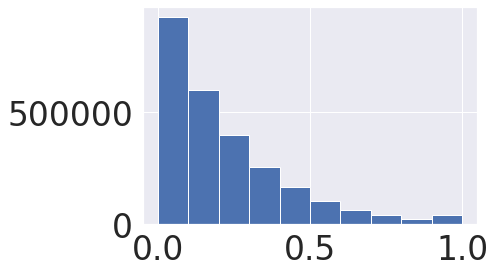

(40, 16, 64, 64, 3)


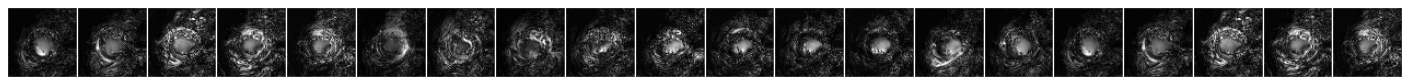

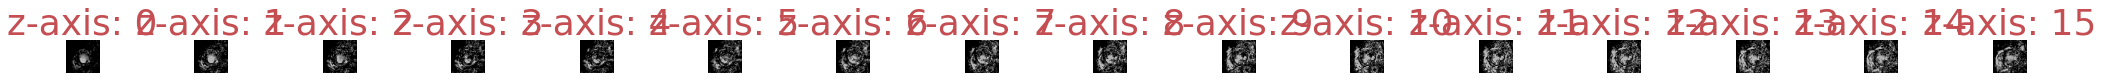

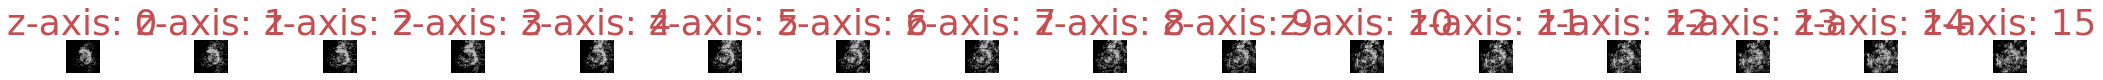

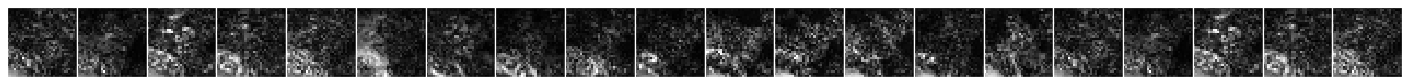

In [12]:
from src.visualization.Visualize import show_2D_or_3D
from src.data.Preprocess import clip_quantile
nda_temp = nda_vects[0]
# norm_1 = nda_temp[:,:,:32,:32]# top left
norm_1 = nda_temp[:,:,:32,32:]# top right
norm_1 = np.linalg.norm(norm_1, axis=-1)
nda_norm_ = np.linalg.norm(nda_temp, axis=-1)
# plot the original norm distribution
plt.hist(nda_norm_.flatten());plt.show()
nda_norm = clip_quantile(nda_norm_, 0.99)
nda_norm = minmax_lambda([nda_norm,0,1])
# plot the quantile clip and normalised norm distribution
plt.hist(nda_norm.flatten())
plt.show()
# mask phi with a threshold norm matrix
nda_msk = np.max(nda_norm,axis=0)
nda_msk = (nda_norm>=0.2).astype(np.float32)[np.newaxis,...]
nda_masked = nda_norm * nda_msk
#plt.hist(nda_temp.flatten())
print(nda_temp.shape)
_ = show_2D_or_3D(nda_norm_[:,0], allow_slicing=True)
_ = show_2D_or_3D(nda_masked[:,0], allow_slicing=True)
_ = show_2D_or_3D(nda_masked[:,-1], allow_slicing=True)

# top right
_ = show_2D_or_3D(norm_1[:,0], allow_slicing=True,cmap='gray', interpolation='none')

## 3.2 Plot the GT cardiac phase as steps over time

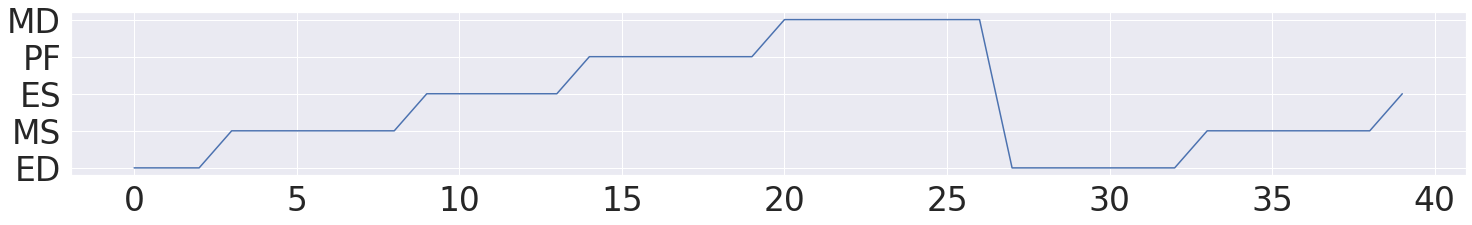

In [13]:
fig, ax = plt.subplots(figsize=(25,3))
plt.plot(np.argmax(gt[0], axis=1))
ax.set_yticks([0, 1, 2, 3, 4], minor=False)
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
_ = ax.set_yticklabels(phases)

## 3.3 Plot the mean/max norm of the example patient

Please note, the peak at the end is caused by the roll operation in the model

In [14]:
np.linalg.norm(nda_temp,axis=-1).shape

(40, 16, 64, 64)

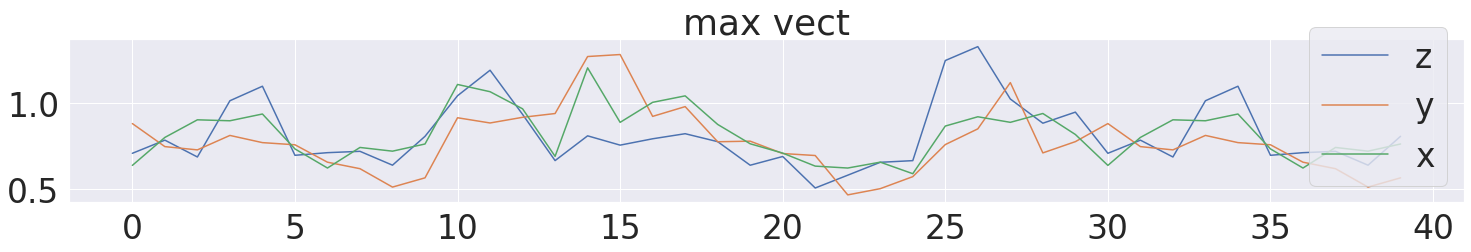

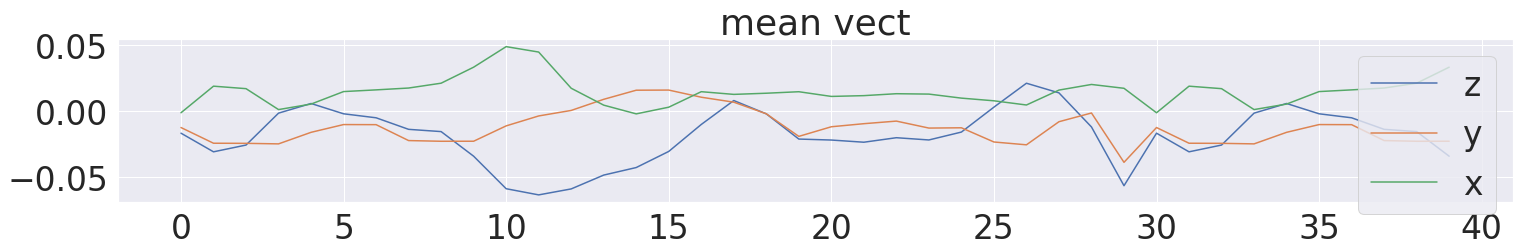

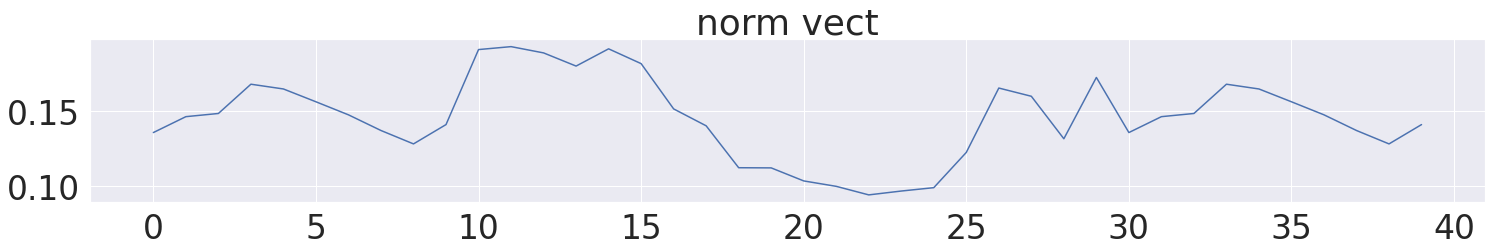

In [15]:
# plot the mean/max norm for one patient over time
# nda_temp: t,z,y,x,c and c = 3 with an order of z,y,x relative deformation
# channels represent the deformable relative direction 
# should have the z,y,x
# blue = channel 0
# orange = channel 1
# green = channel 2
nda_1d_max = np.max(nda_temp,axis=(1,2,3))
nda_1d_mean = np.mean(nda_temp,axis=(1,2,3))
nda_1d_norm = np.mean(np.linalg.norm(nda_temp,axis=-1),axis=(1,2,3))

fig, ax = plt.subplots(figsize=(25,3))
ax.set_title('max vect')
_ = plt.plot(nda_1d_max)
ax.legend(['z','y','x'])

fig, ax = plt.subplots(figsize=(25,3))
ax.set_title('mean vect')
_ = plt.plot(nda_1d_mean)
ax.legend(['z','y','x'])

fig, ax = plt.subplots(figsize=(25,3))
ax.set_title('norm vect')
_ = plt.plot(nda_1d_norm)
#ax.set_ylim(0.0,0.15)

# 4. Predict phases from the frame2frame deformable registration field

Here we define the rules to get from a deformable 5D registration field to the five cardiac phases 

die aktuelle unsupervised "Regel" zur Identifizierung der Phasen als Pseudo-Code (funktioniert ohne vorheriges Alignment an einer Phase):
Ich suche nach den Phasen sequentiell und croppe nach jedem Schritt die Norm und Direction-1D-Vektoren um 
a) sicher zu stellen das die Reihenfolge der Phasen stimmt und 
b) um das Problem jeweils kleiner/einfacher zu machen

Pre-Processing je Patient:
- cropping of each deformable registration fields to the individual CMR sequence length
- mean along the axis Z,X,Y
- 1D-Gaus filter smoothing with a sigma of 2 (smaller or bigger sigma performs worse)
- min/max normalisation in a range of [-1:1]

All operations are called on the whole deformation cycle, 

Sometimes we start from a known phase N, to make sure the phase order is valid. 

Here we concatenate the [sequence[N:],sequence[:N]], by this we can deal with any kind of shifted cardiac cycle
- MS: global argmin(f(x))
- ES: from MS --> first time f(x)>0
- PF: from ES --> first peak, greater 0.5 (note: we normalised to 1-:1)
- ED: between PF and MS --> last time f(x) cross zero from + --> -
- MD: middle idx between PF and ED

In [96]:
def detect_phases(dir_1d_mean, length):
    
    import scipy.signal as sig
    
        # MS
    # Global min of f(x)
#     peaks, prop = sig.find_peaks(-1*dir_1d_mean, height=0.4)
#     if len(peaks)>1:
#         ms = peaks[0]
#     else:
#         ms = np.argmin(dir_1d_mean)
    ms = np.argmin(dir_1d_mean)
    ms = ms -1 # take the bucket before the first min peak
    
    
    # ES
    # First time f(x)>0 after MS
    ms_idx = ms + 1
    cycle = np.concatenate([dir_1d_mean[ms_idx:], dir_1d_mean[:ms_idx]])
    cycle = cycle[:np.argmax()]
    temp_ = 0
    es_found=False
    negative_slope = False
    for idx,elem in enumerate(cycle):
        if elem<0:
            negative_slope=True
            #temp_ = idx
        elif elem>=0 and negative_slope:
            es_found = True
            temp_ = idx
            negative_slope=False
            #break # stop after first zero-transition
    if es_found:
        es = ms_idx + temp_
        #es = es-1
    else:
        es = ms_idx # the frame after ms, fallback
    if es>=length:
        es = np.mod(es,length)
        print('ES overflow: {}, ms:{}'.format(es,ms))
     
    
    # PF
    # First peak after ES, min height 0.6
    es_idx = es + 1
    seq =   np.concatenate([dir_1d_mean[es_idx:], dir_1d_mean[:es_idx]])
    peaks, prop = sig.find_peaks(seq)#height=0.6 we normalise between -1 and 1, PF should be close to argmax
    if len(peaks>0):
        pf = es_idx + peaks[0] # take the peak after es
        #pf = pf -1
    else:
        print('pf not clear, set to ES {} + 1'.format(es))
        pf = es_idx
        
    #pf = np.argmax(dir_1d_mean)

    pf = np.mod(pf, length)
      

    # ED
    # Between pf and ms: last time f(x) cross zero from positive to negative
    # a priori knowledge ED needs a minimal distance of 2 frames towards MS
    # CHANGED the minimal distance between ED and MS
    cycle = np.concatenate([dir_1d_mean[pf:], dir_1d_mean[:ms]])
    #print(cycle)
    ed_found = False
    last_idx_positive = True # we start at the pf, which is the peak(dir)
    for idx,elem in enumerate(cycle):
        
        if elem>=0:
            last_idx_positive = True
        # remember the last idx before the direction gets negative the last time before ms
        elif elem<0 and last_idx_positive: # first time direction negative
            ed_found = True # for fallbacks
            temp_ = idx # idx before negative direction
            #print('found transition at: {}'.format(idx))
            last_idx_positive = False # remember only the first idx after transition
        
    if ed_found:
        ed = pf + temp_
        #print('ed:{}, pf:{}, temp_:{}, lenght: {}'.format(ed,pf,temp_,length))
    else: 
        # if we dont find a transition from positive to negative, take the idx which is the closest to zero
        temp_ = np.argmin(np.abs(cycle)) # make sure we have a minimal distance
        ed = pf + temp_
        print('ED: no transition found between {}-{} , closest id to 0: {}, ed = {}'.format(pf,ms,temp_,ed))
    
    if ed>=length:
        #print('gt ed: {}, ed: {}, length: {}'.format(gted,ed,length))
        ed = np.mod(ed,length)  
    # MD
    # Middle between PF and ED
    ed_slice_idx = ed
    if ed_slice_idx<=pf: # ed overflow --> beginning of cmr stack
        ed_slice_idx = length + ed
    md = (pf+ed_slice_idx)//2 # the bucket after the middle
    md = md + 2
    md = np.mod(md,length)
    
    return np.array([ed,ms,es,pf,md])

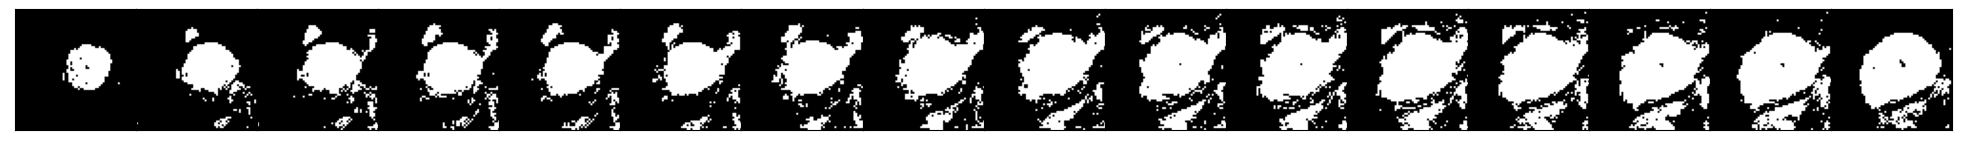

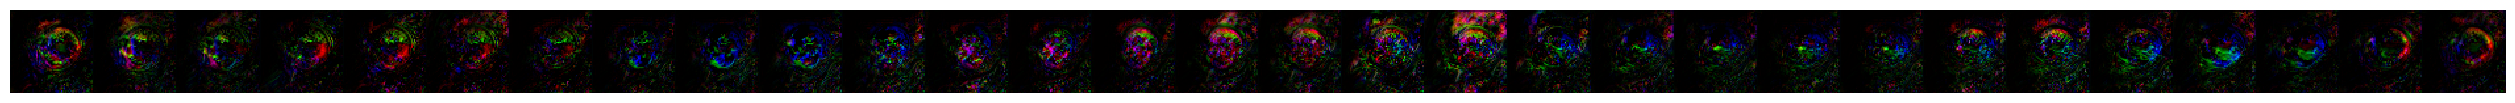

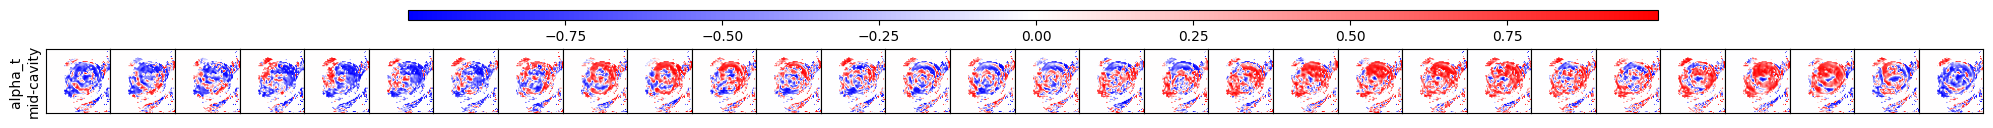

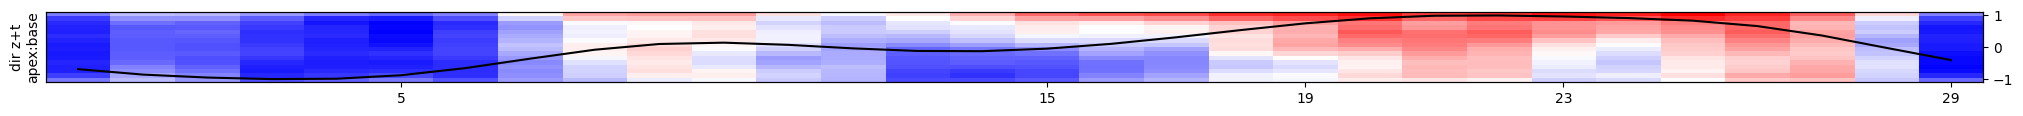

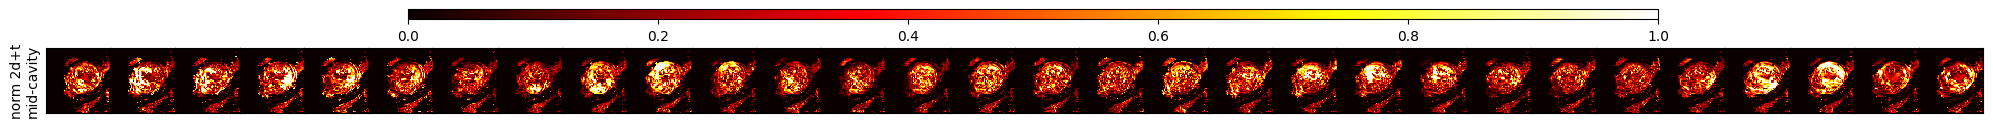

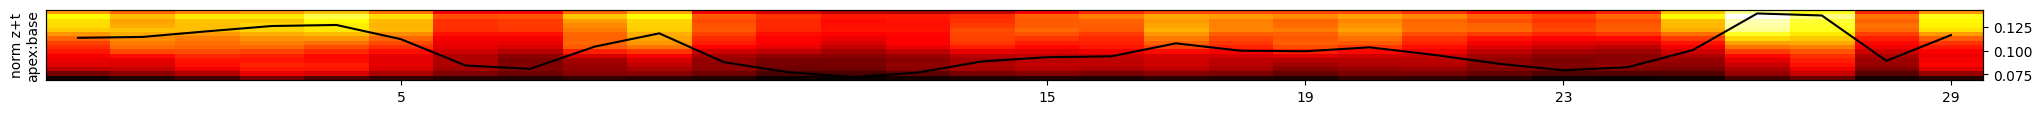

array([28,  2,  8, 10, 21])

In [77]:
# try to predict the phases unsupervised just from the norm/direction curves
centers_tensor = None

def get_phases_from_vects(vects_nda, length=-1, plot=True, dir_axis=0, gtind=[],norm_percentile=0., figsize=(25,3)):
    import scipy.signal
    import scipy.signal as sig
    import scipy.ndimage
    from scipy.ndimage import gaussian_filter1d
    global centers_tensor
    from scipy import ndimage
    
    gted=gtind[0]

    dim_z = vects_nda.shape[1]
    z = dim_z//2
    
    #if centers_tensor is None:# we need that step only once
    #     dim = vects_nda.shape[1:-1]
    #     idx = get_idxs_tf(dim)
    #     c = get_centers_tf(dim)
    #     centers = c - idx
    #     centers_tensor = centers[tf.newaxis, ...]
    
    
    # norm of the vector
    norm_nda = np.linalg.norm(vects_nda[...,dir_axis:], axis=-1)
    norm_nda = clip_quantile(norm_nda, 0.99)
    norm_nda = minmax_lambda([norm_nda,mid,upper])
    #norm_msk = np.stack([minmax_lambda([elem,0,1]) for elem in norm_nda], axis=0)
    
    #norm_msk = minmax_lambda([np.median(norm_nda[:-1], axis=0),mid,upper])# exclude the cyclic norm for mask generation
    #norm_msk = (norm_msk>=np.percentile(norm_msk, norm_percentile)).astype(np.float32)[np.newaxis,...] # this could be used to mask v_t by a threshold norm
    #norm_nda = norm_nda * norm_msk
    
    ######################################## new norm mask according to the mse filtering - 29.03
#     gaus_sigma =1
    norm_msk = norm_nda.copy()
#     #norm_smooth = np.stack([minmax_lambda([elem,0,1]) for elem in norm_smooth], axis=0)
    norm_msk = np.mean(norm_msk[:-1], axis=0)
#     from skimage.measure import label

#     def getLargestCC(segmentation):
#         labels = label(segmentation)
#         assert (labels.max() != 0)  # assume at least 1 CC
#         largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
#         return largestCC
    
#     #norm_msk = ndimage.median_filter(norm_msk,size=3)
#     norm_smooth = ndimage.gaussian_filter(norm_msk, gaus_sigma)
    norm_msk = norm_msk > np.percentile(norm_msk, norm_percentile)
#     norm_msk = ndimage.binary_closing(norm_msk,iterations=2)
    
#     norm_msk = getLargestCC(norm_msk)
#     #print(norm_msk.shape, norm_nda.shape)
    norm_nda = norm_nda * norm_msk
    
    # balanced center, move the volume center towards the greatest motion
    dim_ = vects_nda.shape[1:-1]
    ct = ndimage.center_of_mass(norm_msk)
    ct_center = np.array(dim_)//2
    ct = (ct + ct_center)//2
    #print('center of norm: ',ct)

    idx = get_idxs_tf(dim_)
    c = get_focus_tf(ct,dim_)
    centers = c - idx
    centers_tensor = centers[tf.newaxis, ...]
    
    ######################################## new norm mask according to the mse filtering - 29.03
    
    nda_1d_mean = np.nanmean(norm_nda,axis=(1,2,3))
    nda_1d_max = np.max(norm_nda,axis=(1,2,3))
    nda_1d_median = np.median(norm_nda,axis=(1,2,3))
    
    # direction relative to the center
    directions = flow2direction_lambda([vects_nda,centers_tensor])[...,0].numpy()
    directions = directions * norm_msk
    directions = minmax_lambda([directions,lower,upper])
    
    dir_1d_mean = np.nanmean(directions,axis=(1,2,3))
    dir_1d_median = np.median(directions,axis=(1,2,3))

    
    # Find phases
    # 1st smooth the direction with a rolling averge (kernelsize=4)
    # or via gaussian filter
    # 2nd min/max normalise each direction vector in a range [-1:1]
    dir_1d_mean = gaussian_filter1d(dir_1d_mean, sigma=2, mode='wrap') # original: dir_1d_mean
    # min/max scaling
    dir_1d_mean = minmax_lambda([dir_1d_mean,lower,upper])

    ind = detect_phases(dir_1d_mean=dir_1d_mean[:length], length=length)
    
        # plot the mean/max norm for one patient oveer time
    if plot:
        ################################ new
        fig = show_2D_or_3D(norm_msk,allow_slicing=False)
        plt.show()
        
        # VECT 2D+t
        vect_2d_t = vects_nda[:,z]
        fig1 = show_2D_or_3D(vect_2d_t,allow_slicing=False, f_size=(25,2))
        ax1 = fig1.get_axes()[0]
        _ = ax1.set_ylabel('phi_t \nmid-cavity') # r'$\phi_t$ \nmid-cavity'
        
        # DIR 2D+t
        dir_2d_t = directions[:,z]
        div_cmap = 'bwr'
        fig = show_2D_or_3D(dir_2d_t,allow_slicing=False, f_size=(25,2),cmap=div_cmap)
        ax = fig.get_axes()[0]
        _ = ax.set_ylabel('alpha_t \nmid-cavity') #'alpha_t \nmid-cavity'
        cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
        fig.colorbar(ax.get_images()[len(ax.get_images())//2], cax=cax, orientation='horizontal')
        
        figsize=(25,2)
        rows=2
        pos=1
        fig = plt.figure(figsize=figsize)
        ax=fig.add_subplot(rows,1,pos)
        
        # DIR 2D T x Z
        directions_tz = directions.mean(axis=(2,3))
        _ = ax.imshow(directions_tz.T, aspect='auto', label='aasd', cmap=div_cmap, origin='lower')
        _ = ax.set_xticks(gtind, minor=False)
        ax2 = ax.twinx()
        _ = ax2.plot(dir_1d_mean, c='black',label='dir 1d+t')
        _ = ax.set_yticks([])
        _ = ax.set_ylabel('dir z+t\napex:base')
        ax2.label_outer()
        pos = pos+1

        norm_cmap = 'hot'
        
        # NORM 2D + t
        norm_2d_t = norm_nda[:,z]
        norm_2d_t = minmax_lambda([norm_2d_t,mid,upper])
        fig = show_2D_or_3D(norm_2d_t,allow_slicing=False, f_size=(25,2),cmap=norm_cmap, interpolation='none')
        ax = fig.get_axes()[0]
        _ = ax.set_ylabel('norm 2d+t\nmid-cavity')
        cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
        fig.colorbar(ax.get_images()[0], cax=cax, orientation='horizontal')
        
        figsize=(25,2)
        rows=2
        pos=1
        fig = plt.figure(figsize=figsize)
        ax=fig.add_subplot(rows,1,pos)
        
        # NORM 2D TxZ
        norm2d = minmax_lambda([norm_nda.mean(axis=(2,3)),mid,upper])
        _ = ax.imshow(norm2d.T, aspect='auto', origin='lower',cmap=norm_cmap, interpolation='none')
        _ = ax.set_xticks(gtind, minor=False)
        _ = ax.set_yticks([])
        _ = ax.set_ylabel('norm z+t\napex:base')
        ax2 = ax.twinx()
        _ = ax2.plot(nda_1d_mean, c='black',label='norm 1d+t')
        ax2.label_outer()
        pos = pos+1
        plt.show()

    
    return ind
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
p = 58#215
gt_length = int(gt_len[p,:,0].sum())
ind = np.argmax(gt[p][:gt_length],axis=0)
get_phases_from_vects(nda_vects[p][:gt_length], length=gt_length,plot=True,dir_axis=1, gtind=ind, norm_percentile=70)

# 5. Interactive comparison: GT, norm, direction, unsupervised pred und supervised pred

In [78]:
@interact
def compare_phases(i=(0,nda_vects.shape[0]-1), plot=True, norm_thresh=(0,100,5)):
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    figsize = (25,1)
    weight = 1
    z = 0
    direction_axis = 1 # 0 = z,y,x motion, 1 = y,x motion, z- is negative during systole, y,x positive
    
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    cardiac_cycle_length = int(gt_len[i,:,-1].sum())
    # crop or not
    cardiac_cycle_length_ = gt[i].shape[0]-3 # plot the full length minus border for visualisation
    
    vects = nda_vects[i][:cardiac_cycle_length]
    
    ind = np.argmax(gt[i][:cardiac_cycle_length],axis=0) # 
    ind_pred = np.argmax(pred[i][:],axis=0)
    
    temp = mov[i,:cardiac_cycle_length,z] # cardiac_cycle_length_
    fig = show_2D_or_3D(temp,allow_slicing=False)
    ax = fig.get_axes()[0]
    _ = ax.set_ylabel('CMR 2d+t)\nmid-cavity')
    plt.show()
    
    fig= plt.figure(figsize=figsize)
    ax=fig.add_subplot(111)
    ax.set_xticks(ind, minor=False)
    ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    ax.set_yticklabels(phases, rotation=0)
    ind = np.array(ind)
    onehot_gt = np.zeros((ind.size, cardiac_cycle_length)) # cardiac_cycle_length_
    onehot_gt[np.arange(ind.size), ind] = weight
    #ax.imshow(gt[i][:cardiac_cycle_length].T,aspect='auto') # with uncertainity
    ax.imshow(onehot_gt,aspect='auto', cmap='bone') # gt as binary phase2time mapping
    _ = ax.set_yticklabels(phases)
    ax.set_title('gt')
    ax.margins(0,0)
    
    indices = get_phases_from_vects(vects, length=cardiac_cycle_length, plot=plot,dir_axis=direction_axis, gtind=ind,norm_percentile=norm_thresh, figsize=figsize)

    indices = np.array(indices)
    onehot = np.zeros((indices.size, cardiac_cycle_length)) # cardiac_cycle_length_
    onehot[np.arange(indices.size), indices] = weight
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks(indices, minor=False)
    ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    ax.set_yticklabels(phases, rotation=0)
    plt.imshow(onehot,aspect='auto', cmap='bone')
    _ = ax.set_yticklabels(phases)
    ax.margins(0,0)
    #ax.set_title('prediction')
    plt.show()
    
    print(phases)
    print('gt:', ind)
    print('u: ', indices)
    try: 
        print(patients[i])
    except:
        pass
    
    
    # this would plot the supervised prediction
    #print('p: ', ind_pred)
    """fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks(ind_pred, minor=False)
    ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    ax.set_yticklabels(phases, rotation=45)
    plt.imshow(pred[i][:cardiac_cycle_length].T,aspect='auto')
    _ = ax.set_yticklabels(phases);plt.show()"""
    # patient 107 gcn --> good curve for plotting
    # 200 no cut
    # 125 no cut
    # 194 moderate cut 
    # 134 strong cut-off

interactive(children=(IntSlider(value=49, description='i', max=98), Checkbox(value=True, description='plot'), …

# 6. Predict with unsupervised rule from 4. the phases for all patients

In [97]:
norm_thresh=70
dir_axis = 1
pred_u = np.zeros_like(gt)
upred_ind = []
cycle_len=[]
print(pred_u.shape)
for i in range(pred_u.shape[0]):
    weight = 1
    
    cardiac_cycle_length = int(gt_len[i,:,0].sum())
    cycle_len.append(cardiac_cycle_length)
    ind = np.argmax(gt[i][:cardiac_cycle_length],axis=0)
    #print(gt[i][:cardiac_cycle_length].T.shape)
    
    indices = get_phases_from_vects(nda_vects[i][:cardiac_cycle_length], length=cardiac_cycle_length, gtind=ind,plot=False,dir_axis=dir_axis, norm_percentile=norm_thresh)
    upred_ind.append(indices)
    indices = np.array(indices)
    onehot = np.zeros((indices.size, cardiac_cycle_length))
    onehot[np.arange(indices.size), indices] = weight
    pred_u[i][0:cardiac_cycle_length] = onehot.T
upred_ind=np.stack(upred_ind, axis=0)
cycle_len = np.stack(cycle_len, axis=0)
# re-create a compatible shape for the metric fn
gt_ = np.stack([gt,gt_len], axis=1)
pred_ = np.stack([pred_u,np.zeros_like(pred_u)], axis=1)

# create a dataframe for further plots
from src.utils.Metrics import meandiff
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
res = meandiff(gt_, pred_, apply_sum=False, apply_average=False)
df = pd.DataFrame(res.numpy(), columns=phases)
df['patient'] = patients

(99, 40, 5)


In [98]:
# explore outliers interactive
@interact
def find_outlier(p=phases,thresh=(0,10)):
    # get the patient idx, per label where this method fails the most
    label = phases.index(p)
    error_thres = thresh
    if type(res) != np.ndarray: res.numpy()
    idx_ = np.where(res[:,label]>error_thres)[0]
    try:
        print('patients: {}'.format([patients[i].split('_')[1] for i in idx_]))
    except:
        pass
    print('label:{} \naFD>{}\nPatient idx: {}'.format(phases[label],error_thres,idx_))
    print('gt length: {}'.format(cycle_len[res[:,label]>error_thres]))
    print('gt indices: {}'.format(gt_ind[:,label][(res[:,label]>error_thres)]))
    print('pred indices: {}'.format(upred_ind[:,label][(res[:,label]>error_thres)]))
    print('aFD: {}'.format(res[:,label][res[:,label]>error_thres]))
    temp =df.melt(id_vars='patient', var_name='phase', value_name='cFD')
    return temp[temp['cFD']>thresh]

interactive(children=(Dropdown(description='p', options=('ED', 'MS', 'ES', 'PF', 'MD'), value='ED'), IntSlider…

mean     1.43
SD       1.85
median   1.20
dtype: float32
mean     1.20
SD       1.66
median   1.00
dtype: float32
    mean   SD  median
ED  1.03 1.15    1.00
MS  1.05 0.91    1.00
ES  1.51 2.93    1.00
PF  1.75 2.65    1.00
MD  1.83 1.63    2.00


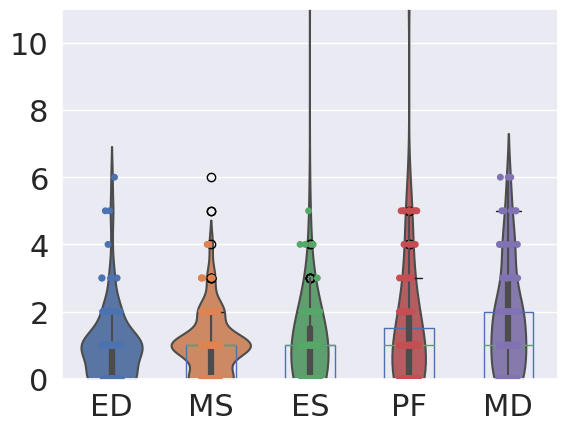

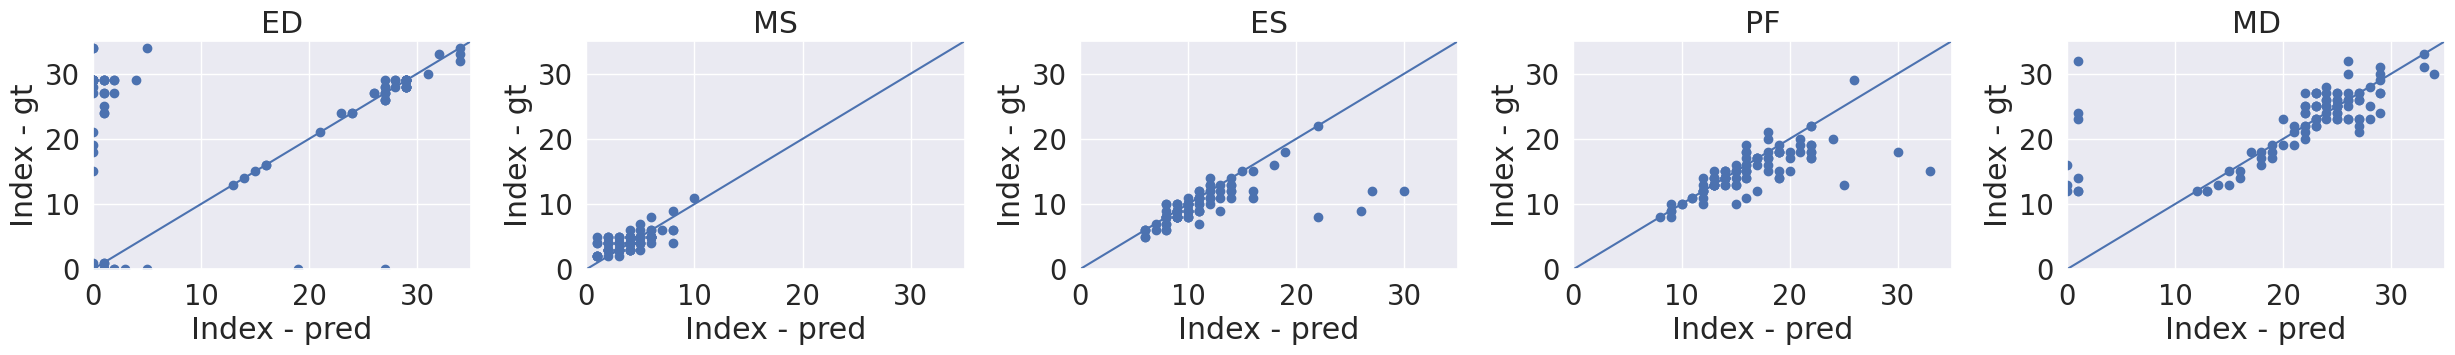

In [99]:
# TOF unsupervised center 14_41 gaus 2
sb.set_context('paper')
sb.set(font_scale = 2)
_ =df.plot(kind='box')
ax = sb.violinplot(data=df)
ax = sb.stripplot(data=df)
ax.set_ylim(0,11)
pd.options.display.float_format = "{:,.2f}".format
df_summarized = pd.concat([df.mean(axis=0),df.std(axis=0), df.median(axis=0)], axis=1)
df_summarized.columns = ['mean', 'SD', 'median']
print(df_summarized.mean())
print(df_summarized.iloc[:3].mean())
print(df_summarized)

sb.set_context('paper')
sb.set(font_scale = 1.8)
fig, axes = plt.subplots(1,5,figsize=(25,4))
axes = axes.flatten()
for i,ax in enumerate(axes):
    _ = ax.scatter(upred_ind[:,i],gt_ind[:,i])
    _ = ax.axline((1, 1), slope=1)
    _ = ax.set_title(phases[i])
    _ = ax.set_xlabel('Index - pred')
    _ = ax.set_ylabel('Index - gt')
    _ = ax.set_xlim([0,35])
    _ = ax.set_ylim([0,35])
plt.tight_layout()

In [99]:
i = 1
temp = pd.DataFrame(np.concatenate([upred_ind,gt_ind], axis=1))

In [100]:
@interact
def calc_corr(i=(0, 4)):
    return scipy.stats.spearmanr(upred_ind[:,i], gt_ind[:,i])

interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

In [40]:
@interact
def calc_corr(i=(0, 4)):
    return scipy.stats.pearsonr(upred_ind[:,i], gt_ind[:,i])

interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

ValueError: x and y must be the same size

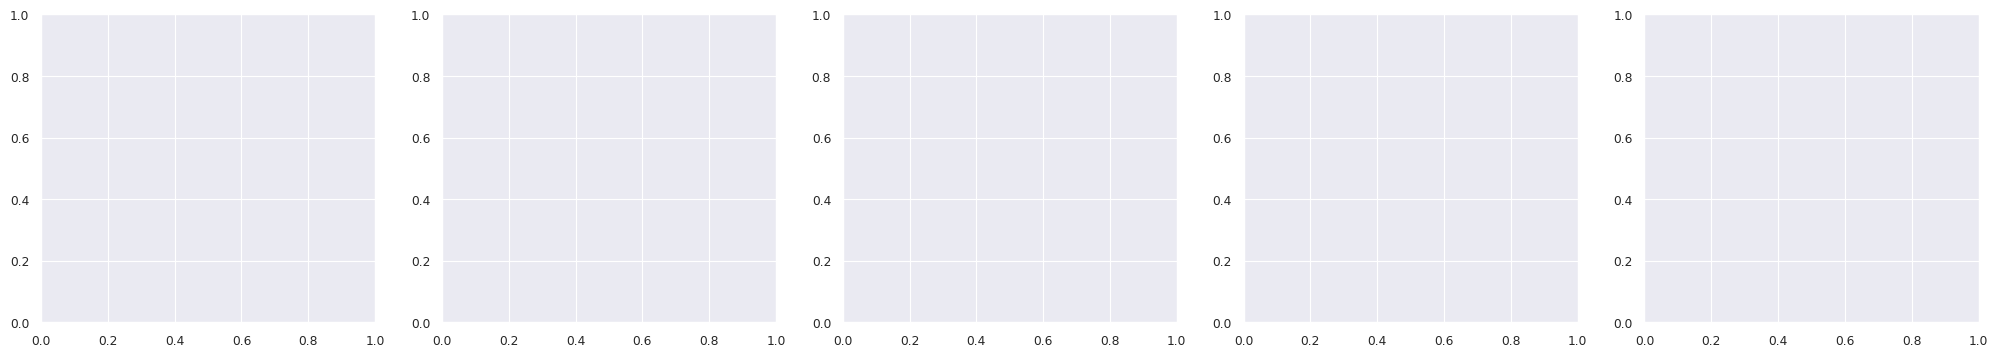

In [233]:
# ACDC unsupervised center
sb.set_context('paper')
fig, axes = plt.subplots(1,5,figsize=(25,4))
axes = axes.flatten()
for i,ax in enumerate(axes):
    _ = ax.scatter(upred_ind[:,i],gt_ind[:,i])
    _ = ax.axline((1, 1), slope=1)
    _ = ax.set_title(phases[i])
    _ = ax.set_xlabel('unsupervised')
    _ = ax.set_ylabel('gt')
    _ = ax.set_xlim([0,35])
    _ = ax.set_ylim([0,35])
    

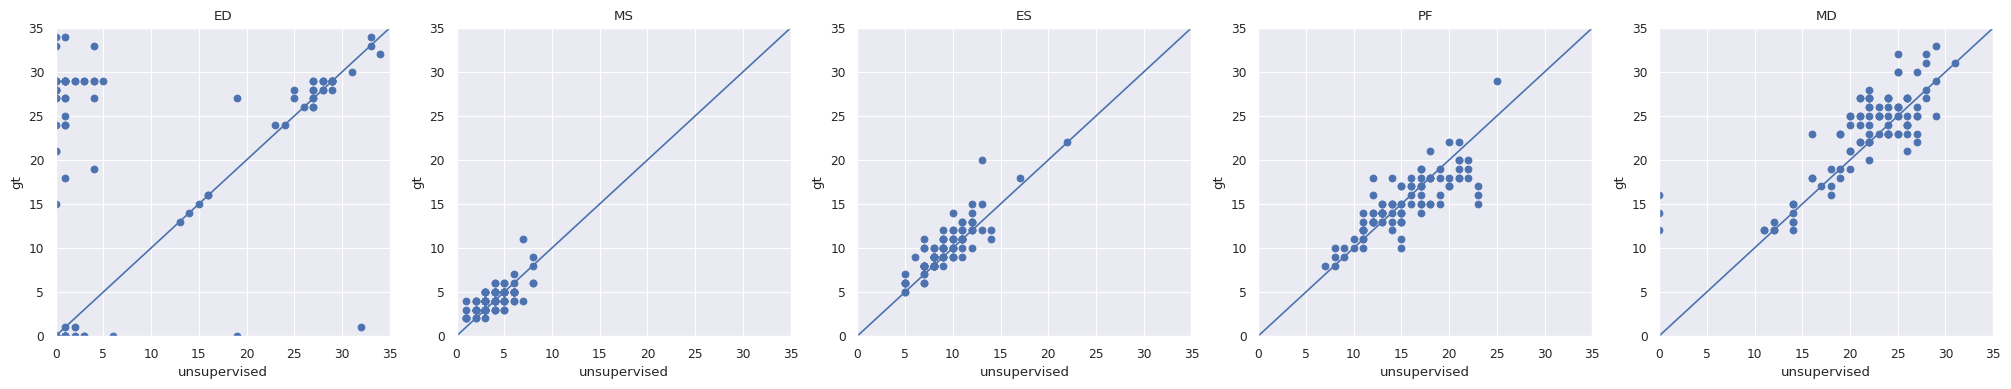

In [30]:
# ACDC unsupervised translate2septum 19_20
sb.set_context('paper')
fig, axes = plt.subplots(1,5,figsize=(25,4))
axes = axes.flatten()
for i,ax in enumerate(axes):
    _ = ax.scatter(upred_ind[:,i],gt_ind[:,i])
    _ = ax.axline((1, 1), slope=1)
    _ = ax.set_title(phases[i])
    _ = ax.set_xlabel('unsupervised')
    _ = ax.set_ylabel('gt')
    _ = ax.set_xlim([0,35])
    _ = ax.set_ylim([0,35])
    

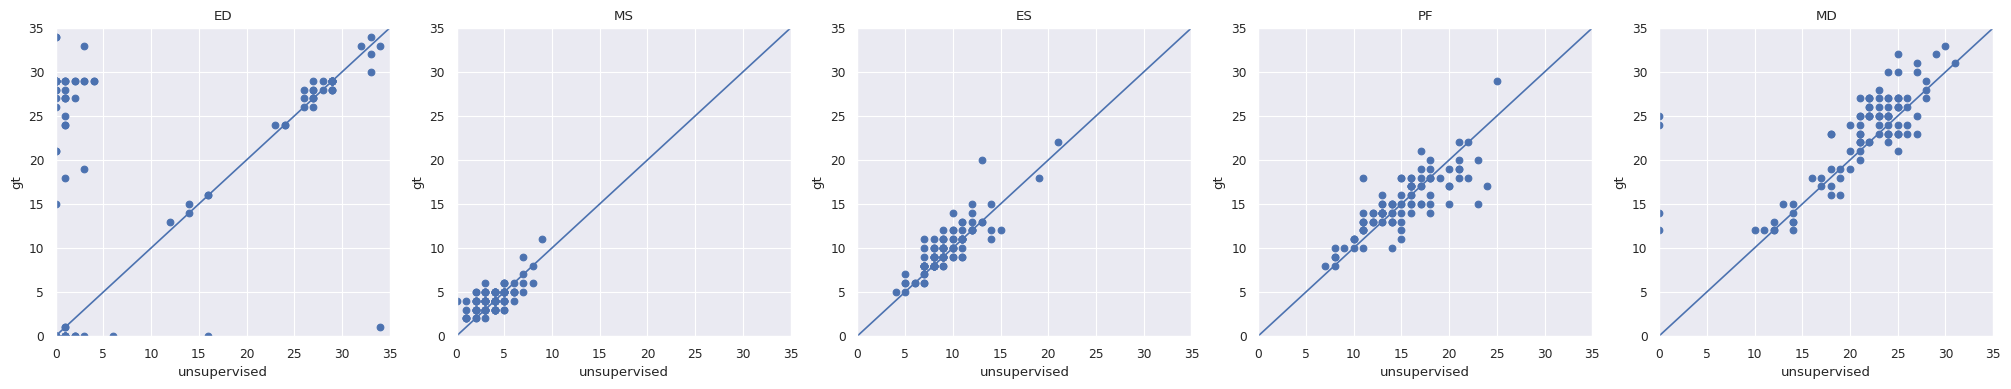

In [307]:
# ACDC unsupervised 19_18
sb.set_context('paper')
fig, axes = plt.subplots(1,5,figsize=(25,4))
axes = axes.flatten()
for i,ax in enumerate(axes):
    _ = ax.scatter(upred_ind[:,i],gt_ind[:,i])
    _ = ax.axline((1, 1), slope=1)
    _ = ax.set_title(phases[i])
    _ = ax.set_xlabel('unsupervised')
    _ = ax.set_ylabel('gt')
    _ = ax.set_xlim([0,35])
    _ = ax.set_ylim([0,35])
    

## 6.1 Plot the unsupervised error per Cardiac Phase

### 6.1.1 TOF

mean      1.51
SD        1.41
meadian   1.20
dtype: float32


mean   SD  meadian
ED  1.57 1.63     1.00
MS  0.98 0.90     1.00
ES  1.07 1.13     1.00
PF  1.71 1.56     1.00
MD  2.20 1.82     2.00

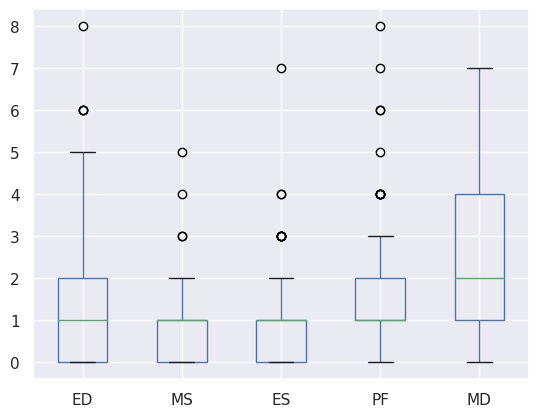

In [122]:
# TOF unsupervised center 14_41 gaus 2
sb.set_context('paper')
sb.set(font_scale = 1)
_ =df.plot(kind='box')
#sb.violinplot(data=df)
pd.options.display.float_format = "{:,.2f}".format
df_summarized = pd.concat([df.mean(axis=0),df.std(axis=0), df.median(axis=0)], axis=1)
df_summarized.columns = ['mean', 'SD', 'meadian']
print(df_summarized.mean())
df_summarized

mean   SD  meadian
ED  1.32 1.44     1.00
MS  1.33 1.06     1.00
ES  1.04 0.93     1.00
PF  1.14 0.91     1.00
MD  1.42 1.18     1.00

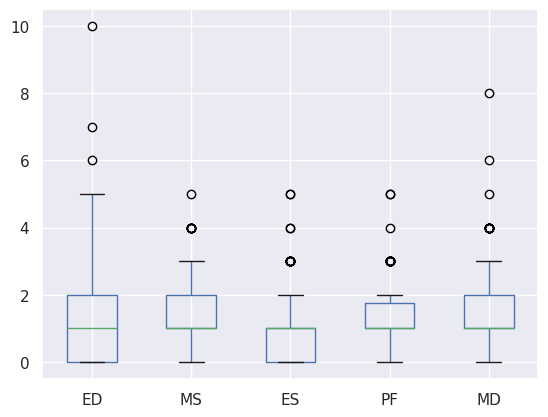

In [107]:
# TOF unsupervised 19_18 gaus 2
sb.set_context('paper')
sb.set(font_scale = 1)
_ =df.plot(kind='box')
pd.options.display.float_format = "{:,.2f}".format
df_summarized = pd.concat([df.mean(axis=0),df.std(axis=0), df.median(axis=0)], axis=1)
df_summarized.columns = ['mean', 'SD', 'meadian']
df_summarized

mean   SD  meadian
ED  1.12 1.11     1.00
MS  0.75 0.68     1.00
ES  0.91 0.84     1.00
PF  0.94 1.04     1.00
MD  1.38 1.18     1.00

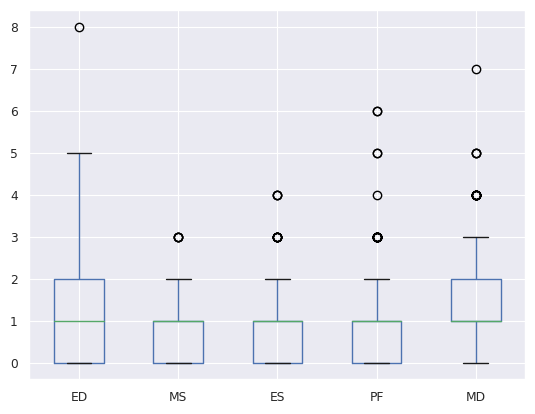

In [259]:
# TOF unsupervised 19_18 gaus 2
sb.set_context('paper')
#sb.set(font_scale = 2)
_ =df.plot(kind='box')
pd.options.display.float_format = "{:,.2f}".format
df_summarized = pd.concat([df.mean(axis=0),df.std(axis=0), df.median(axis=0)], axis=1)
df_summarized.columns = ['mean', 'SD', 'meadian']
df_summarized

mean   SD  meadian
ED  1.04 1.04     1.00
MS  0.75 0.66     1.00
ES  0.90 0.86     1.00
PF  0.98 1.12     1.00
MD  1.40 1.13     1.00

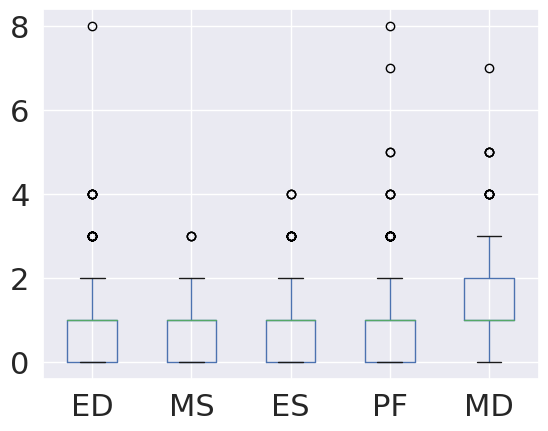

In [149]:
# TOF unsupervised 12_30 gaus 2
sb.set_context('paper')
sb.set(font_scale = 2)
_ =df.plot(kind='box')
pd.options.display.float_format = "{:,.2f}".format
df_summarized = pd.concat([df.mean(axis=0),df.std(axis=0), df.median(axis=0)], axis=1)
df_summarized.columns = ['mean', 'SD', 'meadian']
df_summarized

### 6.1.2 ACDC

mean   SD  meadian
ED  1.37 1.93     1.00
MS  1.16 1.35     1.00
ES  1.11 1.32     1.00
PF  1.79 1.86     1.00
MD  2.51 2.27     2.00

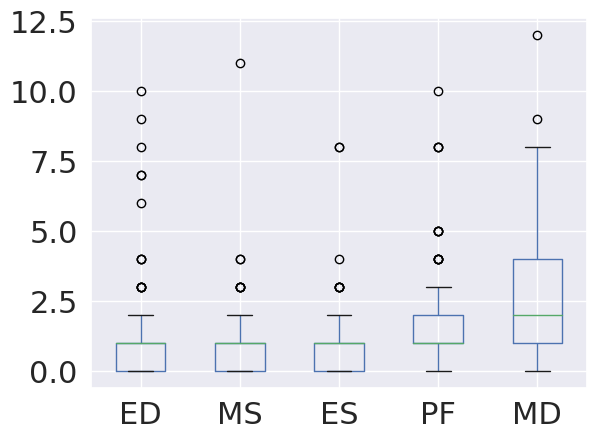

In [162]:
# ACDC unsupervised center fold0 gaus 2 tf2.7
sb.set_context('paper')
sb.set(font_scale = 2)
_ =df.plot(kind='box')
pd.options.display.float_format = "{:,.2f}".format
df_summarized = pd.concat([df.mean(axis=0),df.std(axis=0), df.median(axis=0)], axis=1)
df_summarized.columns = ['mean', 'SD', 'meadian']
df_summarized

mean   SD  meadian
ED  1.57 1.63     1.00
MS  0.98 0.90     1.00
ES  1.07 1.13     1.00
PF  1.71 1.56     1.00
MD  2.20 1.82     2.00

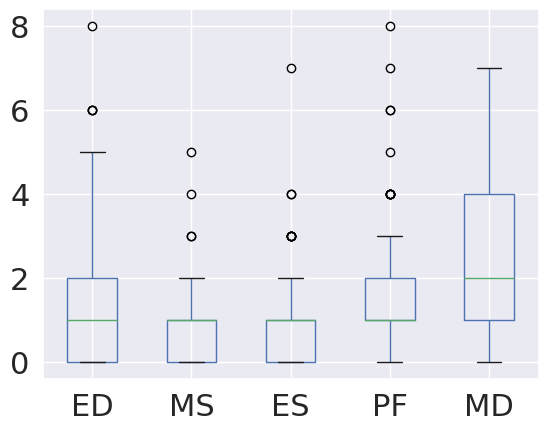

In [29]:
# ACDC unsupervised translate2septum gaus 2 tf2.7
sb.set_context('paper')
sb.set(font_scale = 2)
_ =df.plot(kind='box')
pd.options.display.float_format = "{:,.2f}".format
df_summarized = pd.concat([df.mean(axis=0),df.std(axis=0), df.median(axis=0)], axis=1)
df_summarized.columns = ['mean', 'SD', 'meadian']
df_summarized

mean   SD  meadian
ED  1.31 1.31     1.00
MS  0.99 0.86     1.00
ES  1.03 1.16     1.00
PF  1.65 1.51     1.00
MD  2.12 1.64     2.00

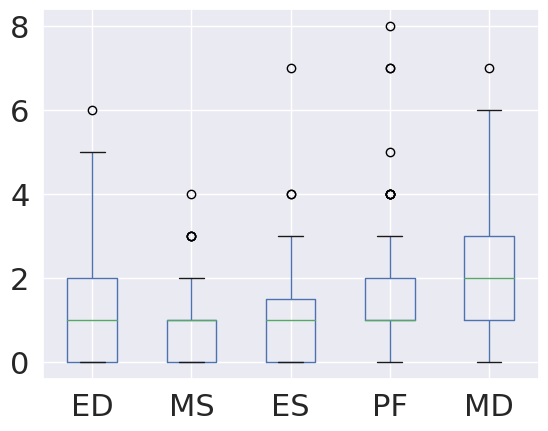

In [303]:
# ACDC unsupervised 19_18 gaus 2 tf2.7
sb.set_context('paper')
sb.set(font_scale = 2)
_ =df.plot(kind='box')
pd.options.display.float_format = "{:,.2f}".format
df_summarized = pd.concat([df.mean(axis=0),df.std(axis=0), df.median(axis=0)], axis=1)
df_summarized.columns = ['mean', 'SD', 'meadian']
df_summarized

mean   SD  meadian
ED  1.18 1.24     1.00
MS  0.99 0.96     1.00
ES  1.13 1.16     1.00
PF  1.67 1.42     1.00
MD  2.30 1.79     2.00

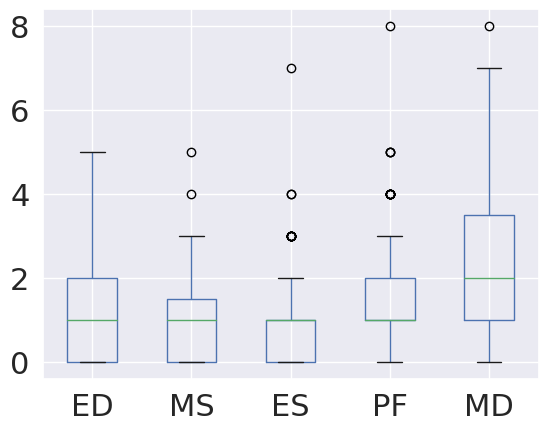

In [173]:
# ACDC unsupervised 12_28 gaus 2
sb.set_context('paper')
sb.set(font_scale = 2)
_ =df.plot(kind='box')
pd.options.display.float_format = "{:,.2f}".format
df_summarized = pd.concat([df.mean(axis=0),df.std(axis=0), df.median(axis=0)], axis=1)
df_summarized.columns = ['mean', 'SD', 'meadian']
df_summarized

ED    1.263158
MS    0.856459
ES    0.789474
PF    1.019139
MD    1.320574
dtype: float32


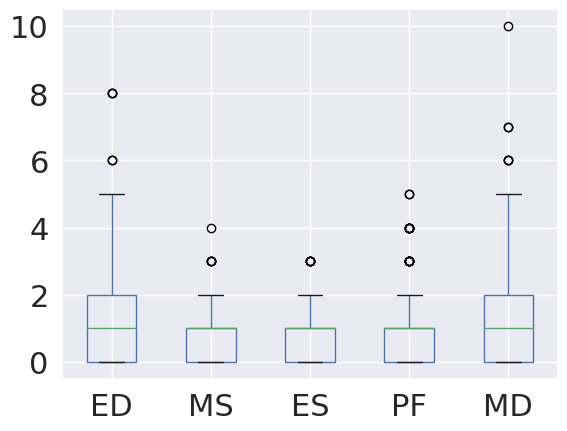

In [383]:
# TOF unsupervised 12_30 min/max normalised
sb.set_context('paper')
sb.set(font_scale = 2)
print(df.mean())
_ =df.plot(kind='box')

ED    0.80
MS    1.40
ES    0.92
PF    2.64
MD    2.12
dtype: float32


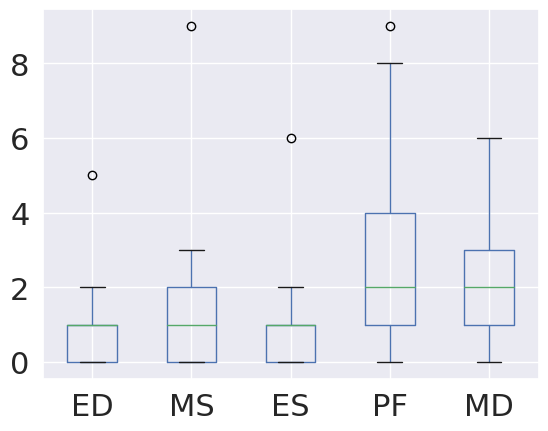

In [46]:
# TOF unsupervised
sb.set_context('paper')
sb.set(font_scale = 2)
print(df.mean())
_ =df.plot(kind='box')

# 7. Additional plots with imshow of vect, direction and magnitude

(16, 64, 64)
(1, 40, 16, 64, 64, 1)


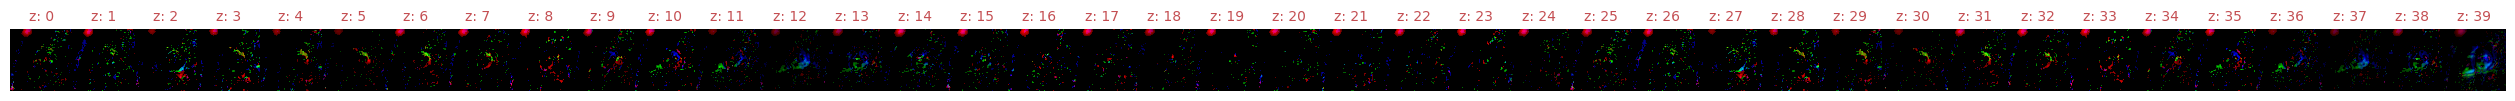

In [30]:
# Take one spatial slice from the middle and plot the vect as RGB image
dim = nda_vects[0].shape[1:-1]
print(dim)
idx = get_idxs_tf(dim)
c = get_centers_tf(dim)
#print('centers: ',c.dtype)
centers = c - idx
centers_tensor = centers[tf.newaxis, ...]
flow2direction_lambda = tf.keras.layers.Lambda(
        lambda x: get_angle_tf(x, centers_tensor), name='flow2direction')
directions = flow2direction_lambda(nda_vects[0:1])
print(directions.shape)
_ = show_2D_or_3D(nda_vects[0,:,4],allow_slicing=False)

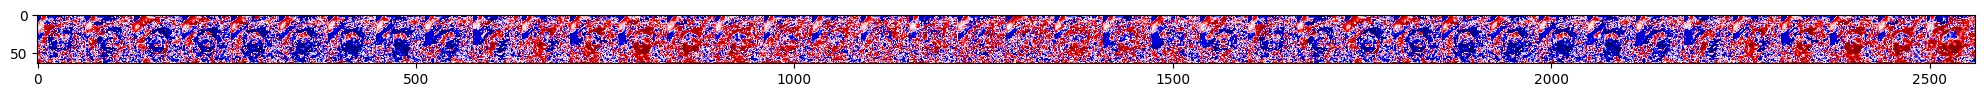

In [31]:
# Take one spatial slice from the middle and plot the direction with seismic scaling
fix, ax = plt.subplots(figsize=(25,5))
temp_dir = directions[0,:,4,...,0]
plt.imshow(np.reshape(temp_dir, (40*64,64)).T, cmap='seismic')

(1, 40, 16, 64, 64)


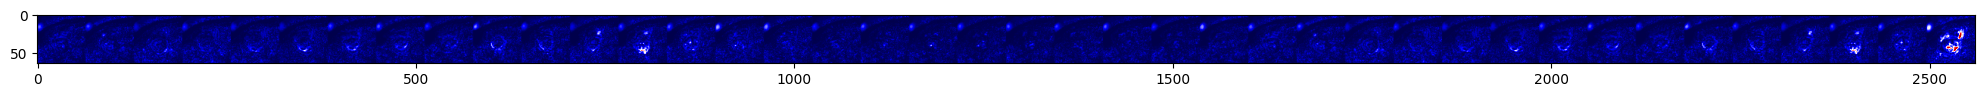

In [32]:
# Take one spatial slice from the middle and plot the vects norm
fix, ax = plt.subplots(figsize=(25,5))
norm_nda = np.linalg.norm(nda_vects[0:1], axis=-1)
print(norm_nda.shape)
temp_dir = norm_nda[0,:,4]
plt.imshow(np.reshape(temp_dir, (40*64,64)).T, cmap='seismic')

## 7.1 Ploting of the vector norm (t and z) & the gt phases for n example patientens

Notes:
- Checked the order of the z axis (starts at apex goes to base)
- bright means greater motion
 
Most of the time:
- more motion (according to the norm of the deformable registration) at the base, than at the apex
- there is a strong negative slope of the norm curve close to the MD phase
- there is a positive peak of the norm curve close to MS and PF

(40, 16)


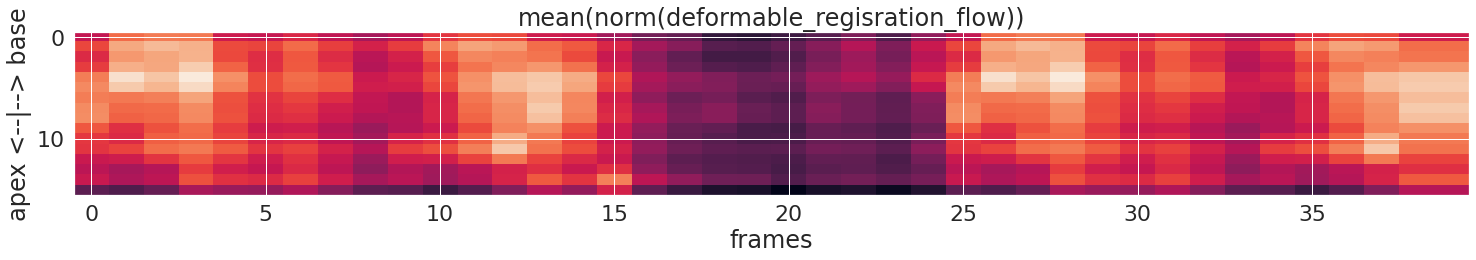

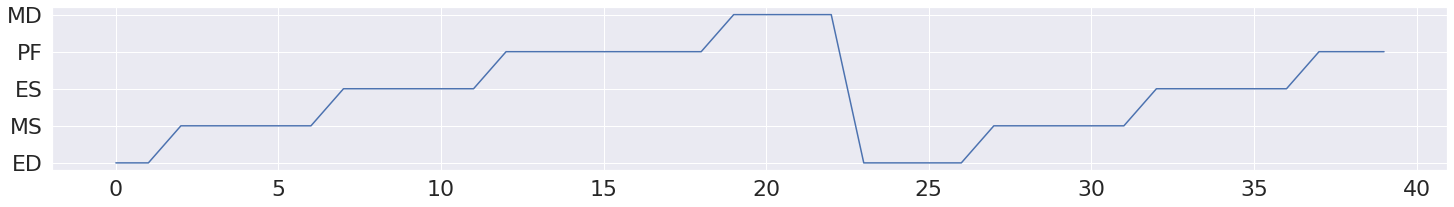

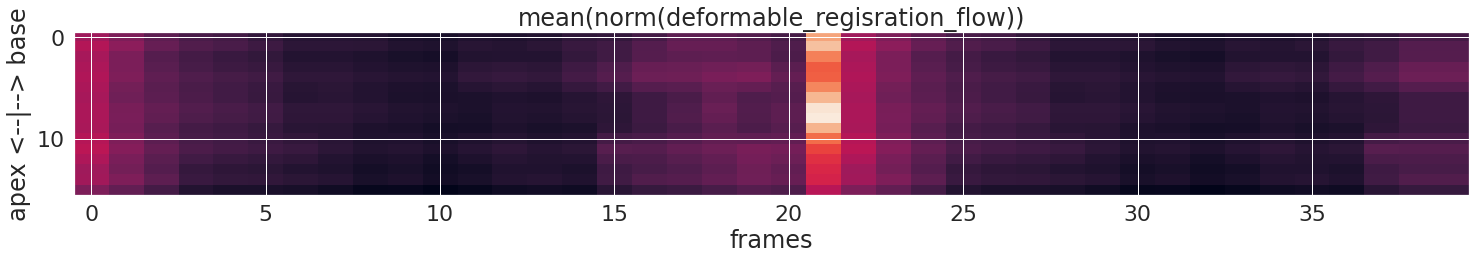

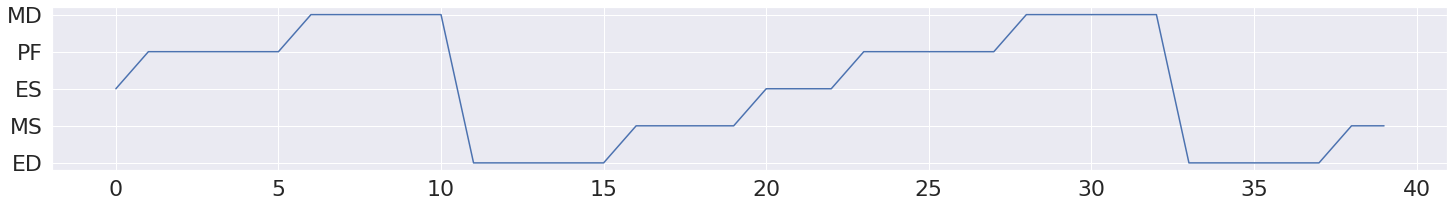

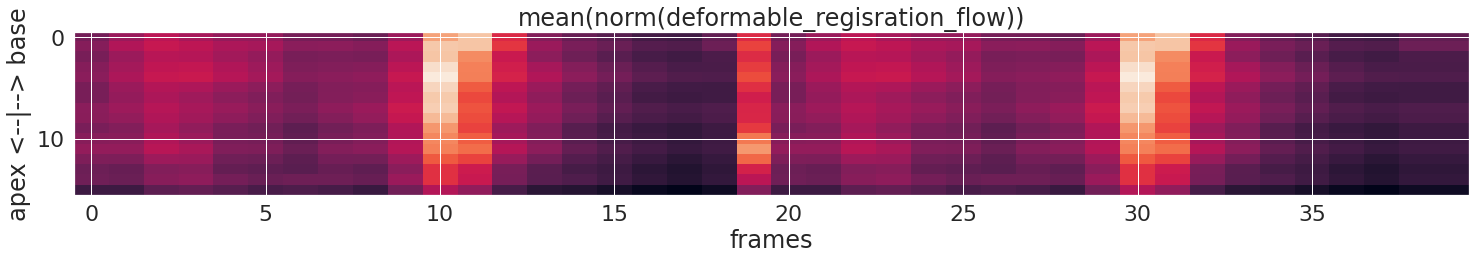

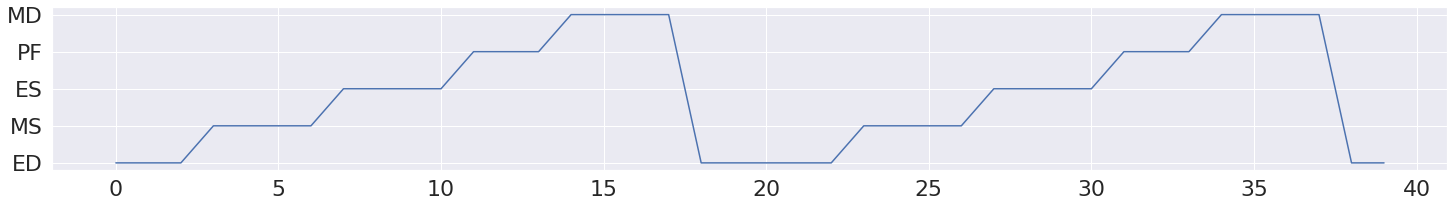

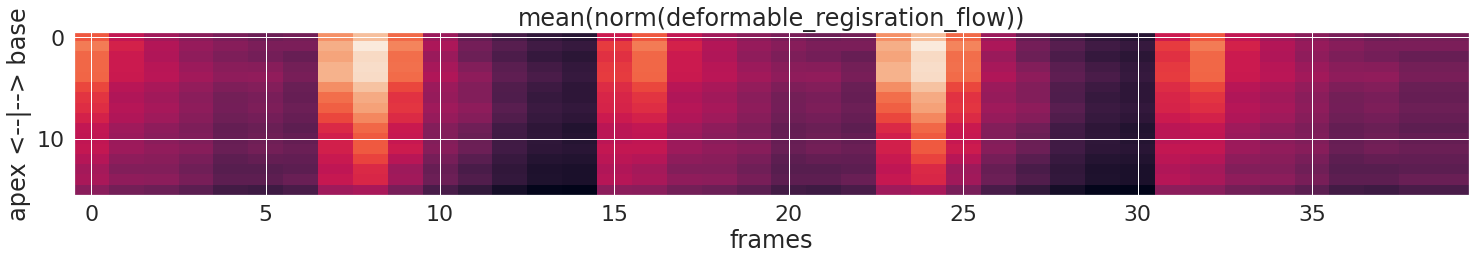

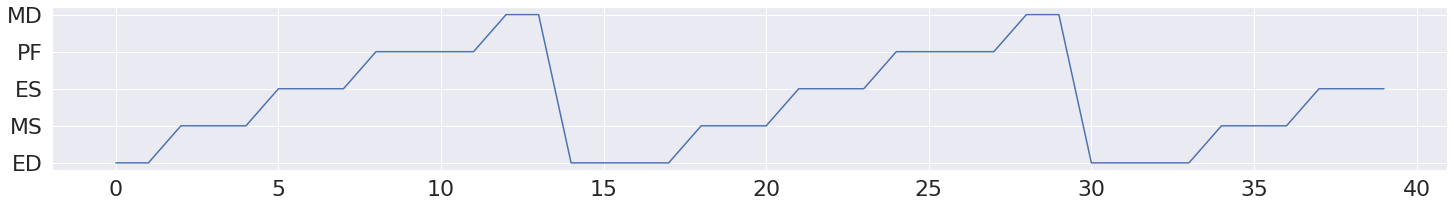

In [21]:
# plot vector norm (t x z) and the gt phases for n patientens
examples = 4
ndas = []
for n in nda_vects[0:examples]:
    ndas.append(np.linalg.norm(n, axis=-1).mean(axis=(2,3)))
print(ndas[0].shape)
for i in range(len(ndas)):
    fig, ax = plt.subplots(figsize=(25,3))
    n = ndas[i]
    n = np.flip(n,axis=1) # after: base 2 apex
    _ = plt.imshow(n.T, aspect='auto')
    _ = ax.set_title('mean(norm(deformable_regisration_flow))')
    _ =ax.set_ylabel('apex <--|--> base')
    _ =ax.set_xlabel('frames')
    
    fig, ax = plt.subplots(figsize=(25,3))
    _ = plt.plot(np.argmax(gt[i], axis=1))
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    _ = ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    _ = ax.set_yticklabels(phases)


## 7.2 Ploting of the vector direction (t and z) & the gt phases for n example patientens

(40, 16, 64, 64, 1)
(40, 16, 64, 64, 1)
(40, 16, 64, 64, 1)
(40, 16, 64, 64, 1)


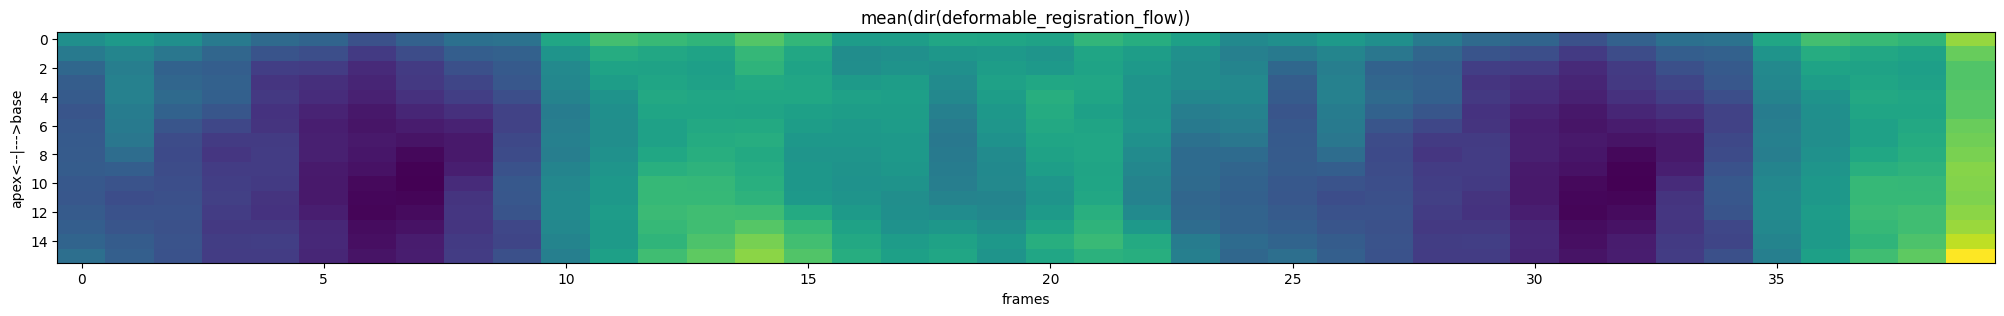

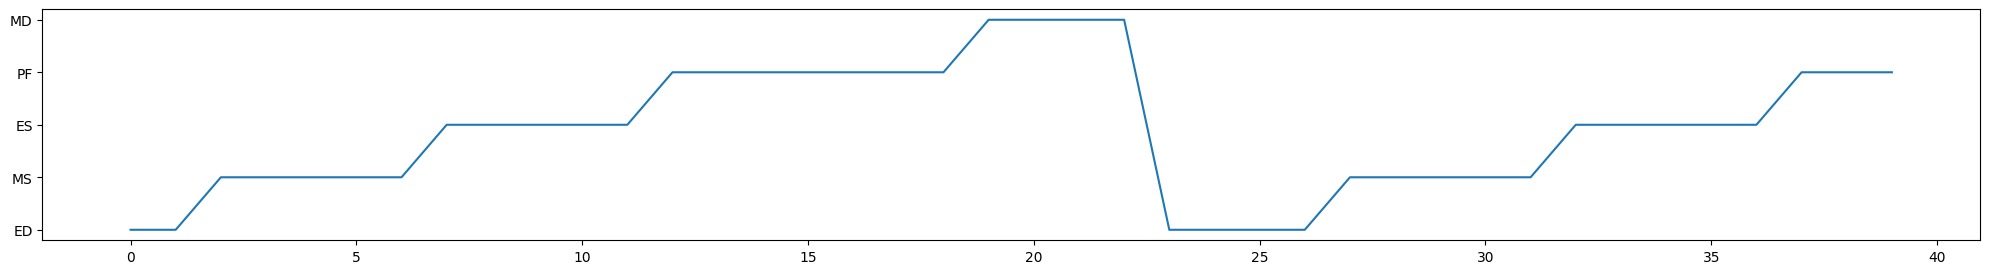

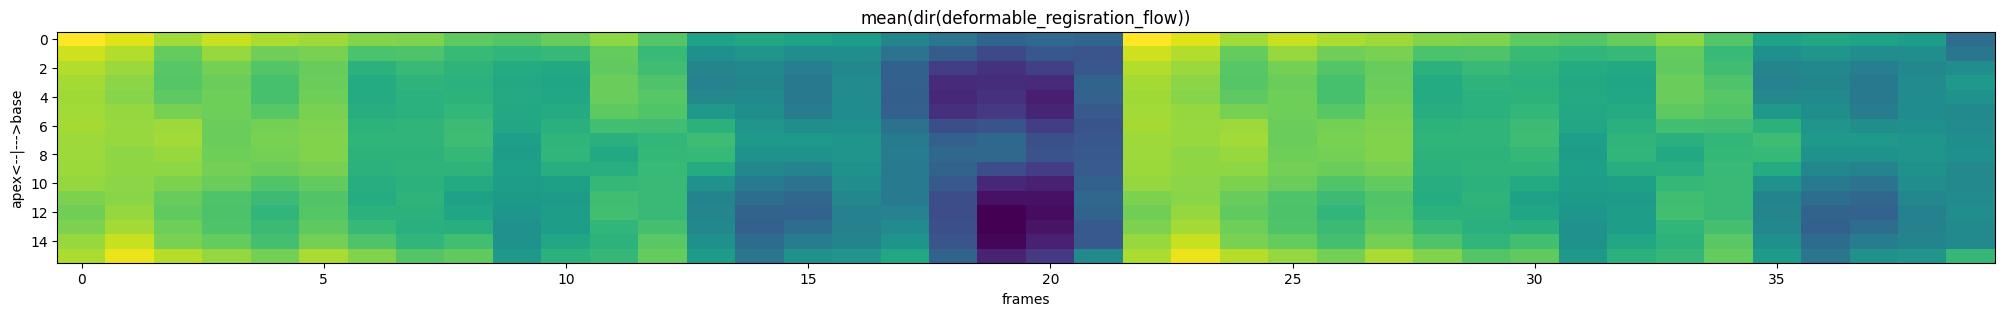

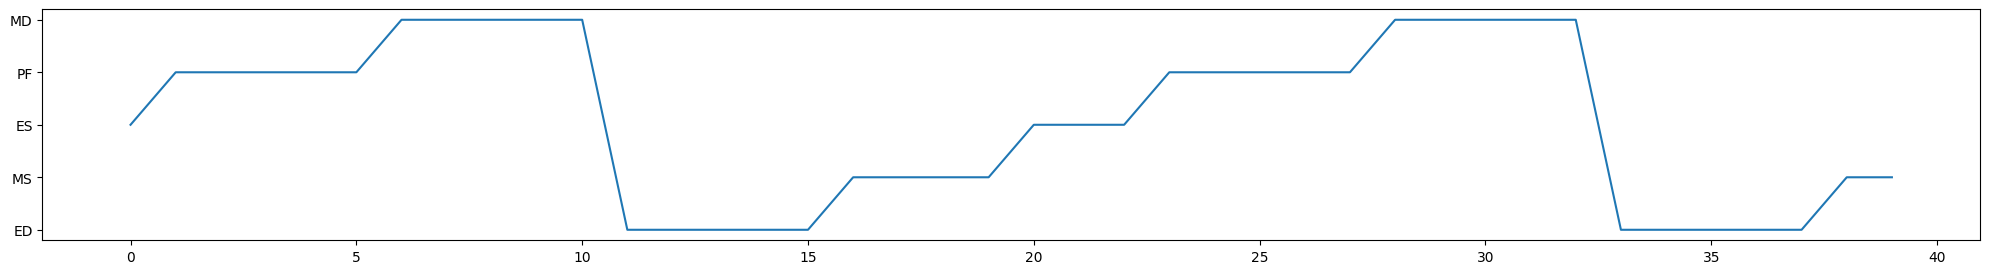

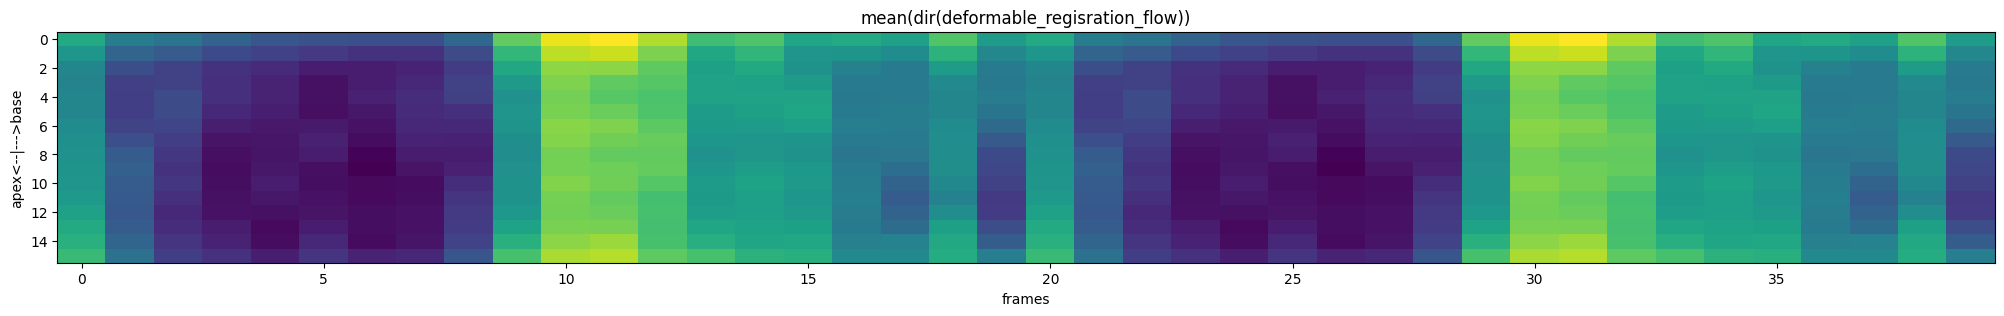

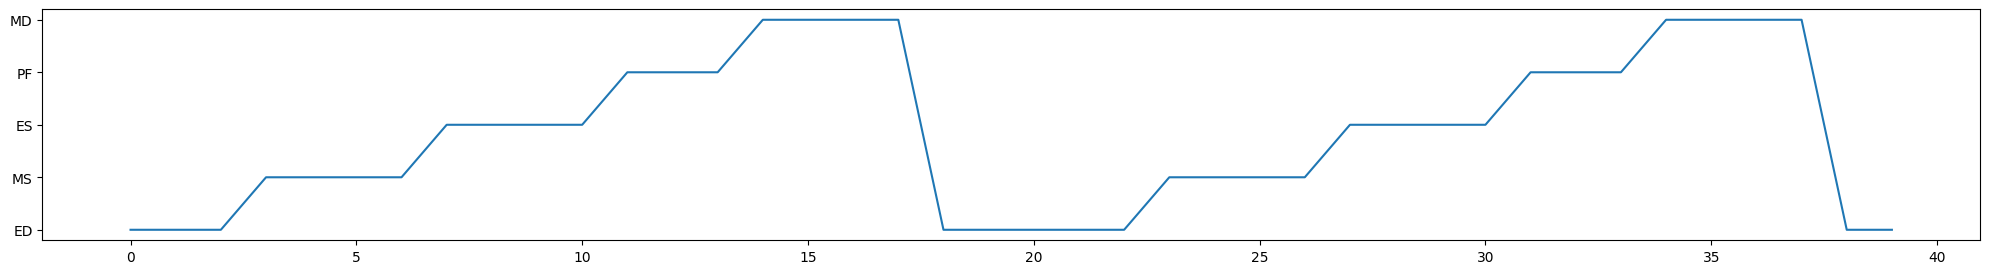

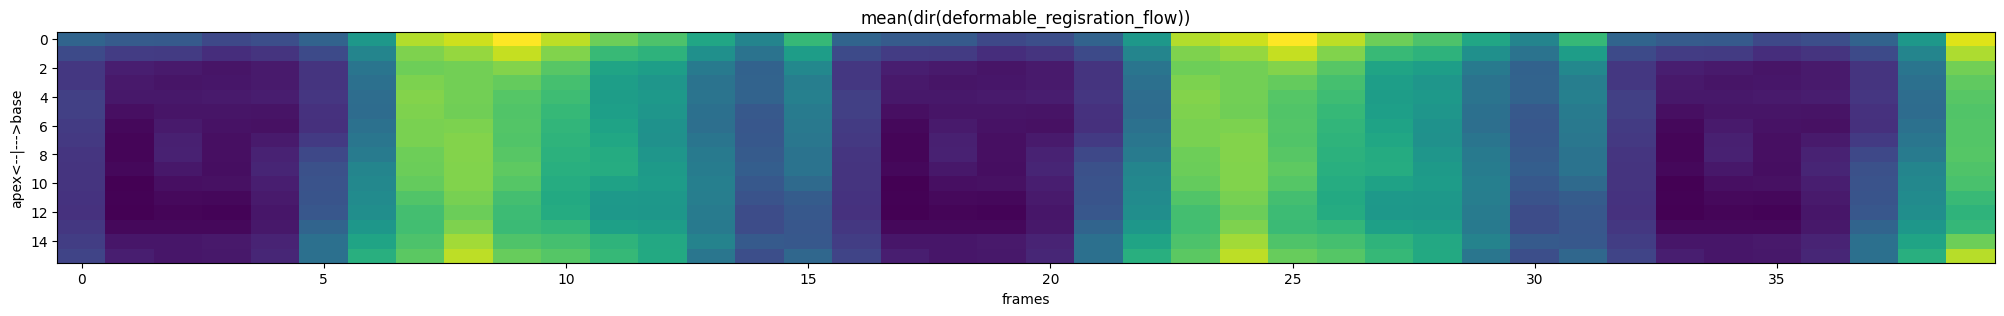

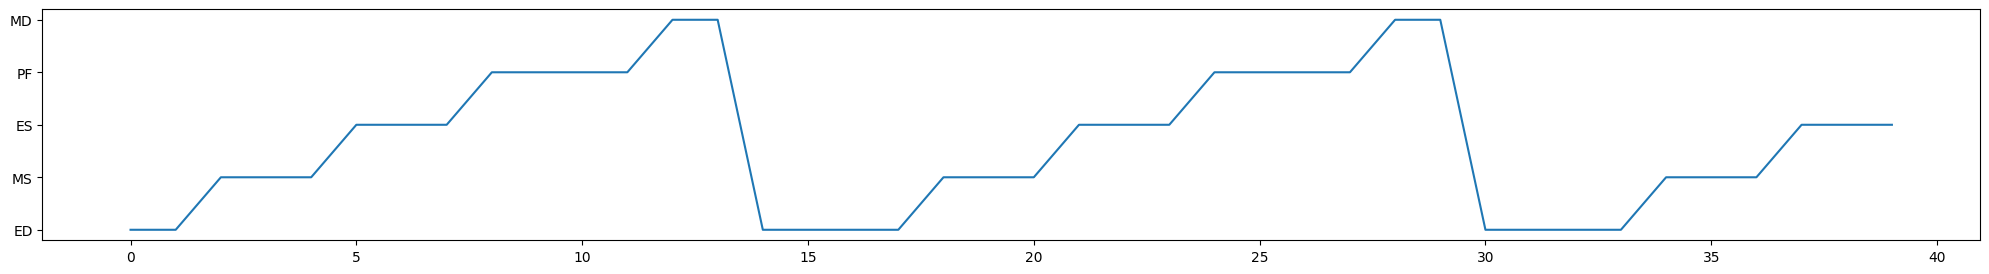

In [33]:
# plot vector direction (t x z) and the gt phases for n patientens
examples = 4
dir_axis=0
ndas = []
dim = nda_vects.shape[2:-1]
#print(dim)
idx = get_idxs_tf(dim)
c = get_centers_tf(dim)
#print('centers: ',c.shape)
centers = c - idx
centers_tensor = centers[tf.newaxis, ...]
flow2direction_lambda = tf.keras.layers.Lambda(
        lambda x: get_angle_tf(x[...,dir_axis:], centers_tensor[...,dir_axis:]), name='flow2direction')
for n in nda_vects[0:examples]:
    directions = flow2direction_lambda(n[np.newaxis,...]).numpy()[0]
    print(directions.shape)
    ndas.append(directions.mean(axis=(2,3))[...,0])
#print(ndas[0].shape)
for i in range(len(ndas)):
    fig, ax = plt.subplots(figsize=(25,3))
    n = ndas[i]
    n = np.flip(n,axis=1)
    #print(n.shape)
    _ = plt.imshow(n.T, aspect='auto')
    _ = ax.set_title('mean(dir(deformable_regisration_flow))')
    _ =ax.set_ylabel('apex<--|--->base')
    _ =ax.set_xlabel('frames')
    
    fix, ax = plt.subplots(figsize=(25,3))
    _ = plt.plot(np.argmax(gt[i], axis=1))
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    _ = ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    _ = ax.set_yticklabels(phases)


# 7.3 temporal aligned plots

Available sources:

gt_ind = np.stack(gt_ind,axis=0)

cycle_len = np.stack(cycle_len, axis=0)

norms = np.stack(norms, axis=0)

dirs = np.stack(dirs, axis=0)

norms_m = [norms.mean(axis=0)]

dirs_m=[dirs.mean(axis=0)]

mov

nda_vects

# 8. Inter-Observer variabillity

Compare Tariques phase-Excel-sheet with original phase for ED and ES from the ACDC dataset

In [182]:
patient_paths = sorted(glob.glob('/mnt/ssd/data/acdc/orig_save/all/*/Info.cfg'))
print(len(patient_paths))
print(patient_paths[0:5])

100
['/mnt/ssd/data/acdc/orig_save/all/patient001/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient002/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient003/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient004/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient005/Info.cfg']


In [183]:
# this patient is excluded due to cut diastolic sequence
patient_paths = [p for p in patient_paths if '090' not in p]
print(len(patient_paths))
print(patient_paths[0:5])

99
['/mnt/ssd/data/acdc/orig_save/all/patient001/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient002/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient003/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient004/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient005/Info.cfg']


In [184]:
patients = [os.path.basename(os.path.dirname(p)) for p in patient_paths]
print(len(patients))
print(patients[0:5])

99
['patient001', 'patient002', 'patient003', 'patient004', 'patient005']


In [185]:
file_4d = glob.glob(os.path.join(os.path.dirname(patient_paths[94]), '*4d.nii.gz'))
print(file_4d)
frames_total = sitk.GetArrayFromImage(sitk.ReadImage(file_4d[0])).shape[0]
print(frames_total)

['/mnt/ssd/data/acdc/orig_save/all/patient096/patient096_4d.nii.gz']
15


In [186]:
import yaml
def read_cfg_file(f):
    """Helper to open cfg files"""
    with open(f, 'r') as yml_file:
        cfg = yaml.load(yml_file, Loader=yaml.FullLoader)
    return cfg

def get_idx(cfg_f):
    patient = os.path.basename(os.path.dirname(cfg_f))
    patient_short = patient.split('patient')[1]
    cfg = read_cfg_file(cfg_f)
    file_4d = glob.glob(os.path.join(os.path.dirname(cfg_f), '*4d.nii.gz'))
    frames_total = sitk.GetArrayFromImage(sitk.ReadImage(file_4d[0])).shape[0]
    frames_total_cfg = int('{:02}'.format(cfg.get('NbFrame', 'NOPHASE')))
    if frames_total != frames_total_cfg:
        print('patient: {} total: {}, total cfg: {}'.format(patient_short, frames_total, frames_total_cfg))
    frame_ed = '{:02}'.format(cfg.get('ED', 'NOPHASE'))
    frame_es = '{:02}'.format(cfg.get('ES', 'NOPHASE'))
    return patient_short, int(frame_ed), int(frame_es), int(frames_total)

In [187]:
idxs = [get_idx(c) for c in patient_paths]

In [188]:
df = pd.DataFrame(idxs, columns=['patient', 'ED#', 'ES#', 'total'])
df

patient  ED#  ES#  total
0      001    1   12     30
1      002    1   12     30
2      003    1   15     30
3      004    1   15     28
4      005    1   13     30
..     ...  ...  ...    ...
94     096    1    8     15
95     097    1   11     30
96     098    1    9     22
97     099    1    9     19
98     100    1   13     34

[99 rows x 4 columns]

In [189]:
df_phase_file = '/mnt/ssd/data/acdc/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase.csv'
df_phase = pd.read_csv(df_phase_file,dtype={'patient':str, 'ED#':int, 'MS#':int, 'ES#':int, 'PF#':int, 'MD#':int})
df_phase = df_phase[['patient', 'ED#','ES#']]
df_phase

patient  ED#  ES#
0        1   29   12
1        2   29   11
2        3   28   14
3        4    0   13
4        5   29   12
..     ...  ...  ...
94      96    0    6
95      97   28   10
96      98   21    8
97      99    0    6
98     100    1   12

[99 rows x 3 columns]

In [10]:
df_phase['total'] = df['total']
df_phase['ED_orig'] = df['ED#']-1
df_phase['ES_orig'] = df['ES#']-1

df_phase['ED_diff'] = df_phase['ED#'] == df_phase['ED_orig']
df_phase['ES_diff'] = df_phase['ES#'] == df_phase['ES_orig']

In [11]:
df_phase['ED_diff'].sum()

21

In [12]:
df_phase['ES_diff'].sum()

55

In [13]:
df_phase['ED#'][0], df_phase['ED_orig'][0], df_phase['total'][0]

(29, 0, 30)

In [14]:
import tensorflow as tf
def get_min_distance(vals):

    smaller = tf.reduce_min(vals[0:2], keepdims=True)
    bigger = tf.reduce_max(vals[0:2], keepdims=True)
    mod = vals[2]

    diff = bigger - smaller
    diff_ring = tf.math.abs(mod - bigger + smaller)# we need to use the abs to avoid 0 - 0
    min_diff = tf.reduce_min(tf.stack([diff, diff_ring]))
    tf.math.greater_equal(min_diff, 0) # this is an int, as we measure the distance between buckets for the metric
    return min_diff


ed_dist_lambda = lambda x : get_min_distance([x['ED#'], x['ED_orig'], x['total']]).numpy()
es_dist_lambda = lambda x : get_min_distance([x['ES#'], x['ES_orig'], x['total']]).numpy()

In [15]:
df_phase['ED_dist'] = df_phase.apply(ed_dist_lambda, axis=1)
df_phase['ES_dist'] = df_phase.apply(es_dist_lambda, axis=1)

In [16]:
df_phase

patient  ED#  ES#  total  ED_orig  ES_orig  ED_diff  ES_diff  ED_dist  \
0        1   29   12     30        0       11    False    False        1   
1        2   29   11     30        0       11    False     True        1   
2        3   28   14     30        0       14    False     True        2   
3        4    0   13     28        0       14     True    False        0   
4        5   29   12     30        0       12    False     True        1   
..     ...  ...  ...    ...      ...      ...      ...      ...      ...   
94      96    0    6     15        0        7     True    False        0   
95      97   28   10     30        0       10    False     True        2   
96      98   21    8     22        0        8    False     True        1   
97      99    0    6     19        0        8     True    False        0   
98     100    1   12     34        0       12    False     True        1   

    ES_dist  
0         1  
1         0  
2         0  
3         1  
4         0  
..      ...  
94        1  
95        0  
96        0  
97        2  
98        0  

[99 rows x 10 columns]

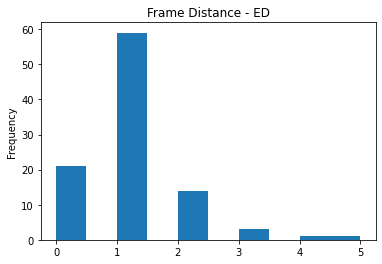

In [17]:
ax = df_phase['ED_dist'].plot(kind='hist')
_ = ax.set_title('Frame Distance - ED')

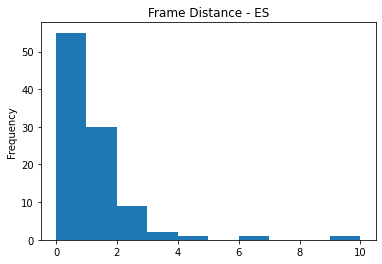

In [18]:
ax = df_phase['ES_dist'].plot(kind='hist')
_ =ax.set_title('Frame Distance - ES')

Mean ED 1.07 +/- 0.86
Mean ES 0.919 +/- 1.6


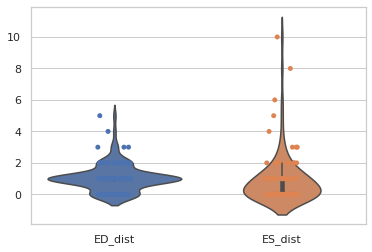

In [31]:
import seaborn as sb
sb.set_theme(style="whitegrid")
sb.violinplot(data=df_phase[['ED_dist','ES_dist']])
sb.stripplot(data=df_phase[['ED_dist','ES_dist']])
print('Mean ED {:1.3} +/- {:1.3}'.format(df_phase['ED_dist'].mean(), df_phase['ED_dist'].std()))
print('Mean ES {:1.3} +/- {:1.3}'.format(df_phase['ES_dist'].mean(), df_phase['ES_dist'].std()))

In [19]:
from ipywidgets import interact, widgets
@interact
def inspect_frame_diffs(patients='', 
                        ed_diff=(widgets.IntSlider(min=0,max=15,step=1,value=15)),
                        es_diff=(widgets.IntSlider(min=0,max=15,step=1,value=15)),
                       greater_as=False):
    temp = df_phase.copy()
    if len(patients) > 0:
        temp = df_phase[df_phase['patient'].str.contains(patients)]
    if greater_as:
        temp = temp[(temp['ED_dist']>=ed_diff) | (temp['ES_dist']>=es_diff)]
    else:
        temp = temp[(temp['ED_dist']<=ed_diff) | (temp['ES_dist']<=es_diff)]
    print(temp.shape)
    return temp

interactive(children=(Text(value='', description='patients'), IntSlider(value=15, description='ed_diff', max=1…

# 9. GT distribution from dataframe

In [216]:
df_phase_file = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase.csv'
df_phase = pd.read_csv(df_phase_file,dtype={'patient':str, 'ED#':int, 'MS#':int, 'ES#':int, 'PF#':int, 'MD#':int})
df_phase = df_phase[['ED#','MS#','ES#','PF#','MD#']]

In [217]:
df_phase.max()

ED#    34
MS#    18
ES#    22
PF#    25
MD#    30
dtype: int64

In [218]:
df_phase.idxmin(1).value_counts()

MS#    955
ED#    420
PF#      5
ES#      5
MD#      5
dtype: int64

ED#   15.54
MS#    4.91
ES#    9.39
PF#   13.22
MD#   18.44
dtype: float64
ED#   10.09
MS#    1.72
ES#    2.11
PF#    2.41
MD#    3.34
dtype: float64


<AxesSubplot:ylabel='Frequency'>

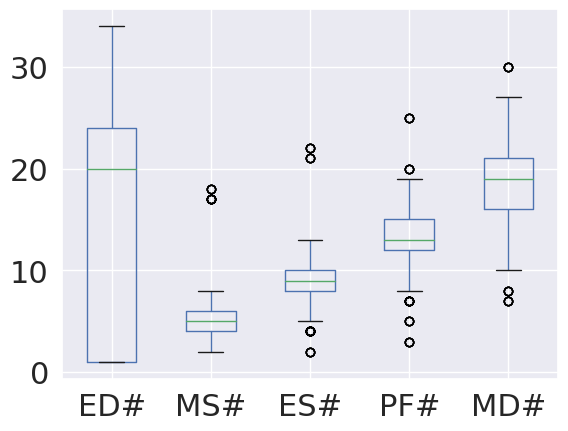

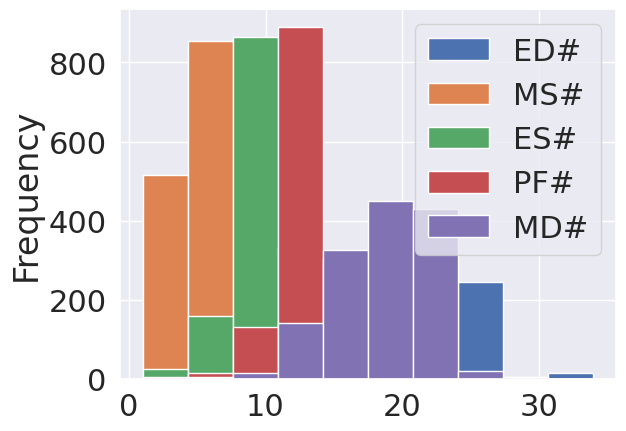

In [219]:
print(df_phase.mean())
print(df_phase.std())
ax = df_phase.plot.box()
df_phase.plot.hist()

In [194]:
df_phase_file = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase.csv'
df_phase = pd.read_csv(df_phase_file,dtype={'patient':str, 'ED#':int, 'MS#':int, 'ES#':int, 'PF#':int, 'MD#':int})

In [195]:
df_phase = df_phase[['ED#','MS#','ES#','PF#','MD#',]]
df_phase.idxmin(1).value_counts()/5

MS#   191.00
ED#    84.00
PF#     1.00
ES#     1.00
MD#     1.00
dtype: float64

ED#   15.54
MS#    4.91
ES#    9.39
PF#   13.22
MD#   18.44
dtype: float64
ED#   10.09
MS#    1.72
ES#    2.11
PF#    2.41
MD#    3.34
dtype: float64


<AxesSubplot:ylabel='Frequency'>

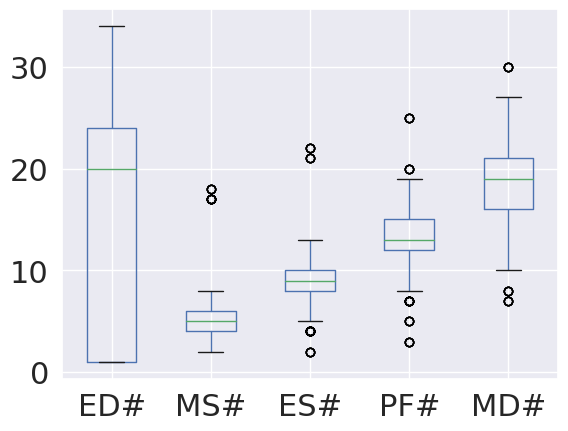

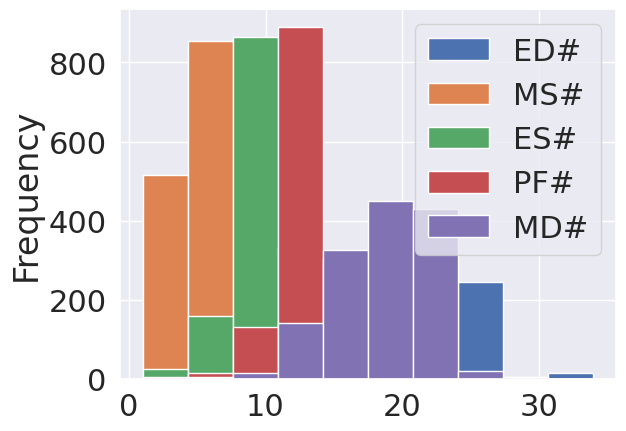

In [196]:
print(df_phase.mean())
print(df_phase.std())
ax = df_phase.plot.box()
df_phase.plot.hist()